In [1]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from biomart import BiomartServer
from io import StringIO
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

numpy	1.26.4
pandas	2.2.3
scanpy	1.11.1
infercnvpy	0.6.0
matplotlib	3.10.0
biomart	0.9.2
anndata	0.11.4
scikit-learn	1.5.2
scipy	1.15.2
----	----
legacy-api-wrap	1.4.1
debugpy	1.6.7
numba	0.61.2
pytz	2024.1
six	1.17.0
pycairo	1.28.0
jaraco.collections	5.1.0
igraph	0.11.8
ipywidgets	8.1.6
jaraco.context	5.3.0
decorator	5.2.1
prompt_toolkit	3.0.51
h5py	3.13.0
stack_data	0.6.3
numexpr	2.10.1
ipython	9.2.0
comm	0.2.2
Pygments	2.19.1
backports.tarfile	1.2.0
setuptools	78.1.1
tqdm	4.67.1
parso	0.8.4
typing_extensions	4.13.2
pillow	11.1.0
matplotlib-inline	0.1.7
jedi	0.19.2
packaging	24.2
Brotli	1.0.9
pywin32	304
more-itertools	10.3.0
session-info2	0.1.2
platformdirs	4.3.7
executing	2.2.0
Bottleneck	1.4.2
charset-normalizer	3.4.2
pure_eval	0.2.3
texttable	1.7.0
threadpoolctl	3.6.0
ipykernel	6.29.5
idna	3.10
jaraco.functools	4.0.1
llvmlite	0.44.0
mkl-service	2.4.0
joblib	1.4.2
jaraco.text	3.12.1
kiwisolver	1.4.8
pyzmq	25.0.2
natsort	8.4.0
PyYAML	6.0.2
jupyter_client	8.6.3
traitlets	5.14.3
colorama	0.4.6
leidenalg	0.10.2
asttokens	3.0.0
certifi	2025.4.26 (2025.04.26)
psutil	5.9.5
pyparsing	3.2.0
python-dateutil	2.9.0.post0
requests	2.32.3
tornado	6.4.2
urllib3	2.4.0
defusedxml	0.7.1
jupyter_core	5.7.2
wcwidth	0.2.13
pyreadr	0.5.3
cycler	0.11.0 (0.10.0)
----	----
Python	3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
OS	Windows-10-10.0.26100-SP0
CPU	6 logical CPU cores, Intel64 Family 6 Model 158 Stepping 12, GenuineIntel
GPU	No GPU found
Updated	2025-05-06 11:25

In [3]:
# Functions
def fetch_positions(adata):
    # Connect to Ensembl Biomart server
    server = BiomartServer("http://grch37.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']

    # Query gene names for only missing gene positions
    no_positions = adata[:, adata.var[['start', 'end']].isna().any(axis=1)]
    with_positions = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)]
    response = dataset.search({
        'filters':{'ensembl_gene_id':list(no_positions.var['gene_ids'])},
        'attributes':['ensembl_gene_id','chromosome_name','start_position','end_position','strand']
    })

    # Convert response to DataFrame and merge with adata.var if response is successful
    if response.status_code == 200:
        print("Request successful!")
        gene_annotations_df = pd.read_csv(StringIO(response.text),sep='\t',header=None)
        gene_annotations_df.columns = ['gene_ids','chromosome','start','end','strand']
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

    # Isolate fetched genes from BioMart in no_positions adata
    fetched_positions = no_positions[:, no_positions.var['gene_ids'].isin(gene_annotations_df['gene_ids'])].copy()

    # Sort fetched genes based on ensembl gene IDs
    fetched_positions = fetched_positions[:, fetched_positions.var['gene_ids'].argsort()].copy()

    # Add the fetched gene positions to the adata
    fetched_positions.var['chromosome'] = gene_annotations_df['chromosome'].values
    fetched_positions.var['start'] = gene_annotations_df['start'].values
    fetched_positions.var['end'] = gene_annotations_df['end'].values
    fetched_positions.var['strand'] = gene_annotations_df['strand'].values

    # Concatenate fetched genes with isolated genes already with positions
    adClean = ad.concat([with_positions, fetched_positions], axis=1)

    # Include obs into the cleaned adata
    adClean.obs = with_positions.obs.copy()

    return adClean

def standardize_chromosomes(adata):
    
    adata1 = adata.copy()

    # Add 'chr' prefix to chromosome names
    adata1.var['chromosome'] = 'chr' + adata1.var['chromosome'].astype(str)

    # Define standard chromosome names with 'chr' prefix
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']

    # Filter adata to include only genes on standard chromosomes
    adata1 = adata1[:, adata1.var['chromosome'].isin(standard_chromosomes)].copy()

    return adata1

def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=30000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean

def downsample(adata,n_cells):
    if adata.n_obs <= n_cells:
        return adata
    else:
        return adata[np.random.choice(adata.obs_names, n_cells, replace=False), :].copy()
    

def log_freeman_tukey_transform(expr_mat):
    """
    Freeman-Tukey variance stabilizing transformation:
    log2(sqrt(x) + sqrt(x+1))
    """
    return np.log2(np.sqrt(expr_mat) + np.sqrt(expr_mat + 1))

def identify_diploid_cells_high_precision(adata,
                                           window=10,
                                           n_components=3,
                                           n_pcs=20,
                                           primary_trim_percentile=100,
                                           secondary_trim_percentile=30):
    """
    Identify diploid cells by:
    - Selecting lowest-variance GMM cluster (primary)
    - Adding central portion of second-lowest variance cluster (secondary)
    - Based on PCA + GMM and genomic smoothing
    """
    expr_raw = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    expr_df = pd.DataFrame(expr_raw, index=adata.obs_names, columns=adata.var_names)
    gene_order = adata.var.sort_values(['chromosome', 'start']).index
    expr_df = expr_df[gene_order]

    # Smoothing
    expr_smooth = expr_df.T.rolling(window=window, min_periods=1, center=True).mean().dropna().T
    expr_smooth = expr_smooth.loc[:, ~expr_smooth.columns.duplicated()]

    # PCA
    pca = PCA(n_components=n_pcs)
    pcs = pca.fit_transform(expr_smooth)

    # GMM Clustering
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    labels = gmm.fit_predict(pcs)

    # Rank clusters by composite score = variance × size
    cluster_variances = [expr_smooth.iloc[labels == i].var(axis=1).mean() for i in range(n_components)]
    cluster_sizes = [np.sum(labels == i) for i in range(n_components)]
    composite_score = [v * s for v, s in zip(cluster_variances, cluster_sizes)]
    sorted_clusters = np.argsort(composite_score)

    # --- PRIMARY cluster (lowest variance): take central X%
    primary_cluster = sorted_clusters[0]
    primary_idx = np.where(labels == primary_cluster)[0]
    primary_pcs = pcs[primary_idx]
    center1 = primary_pcs.mean(axis=0).reshape(1, -1)
    dist1 = cdist(primary_pcs, center1).flatten()
    thresh1 = np.percentile(dist1, primary_trim_percentile)
    keep_primary = primary_idx[dist1 <= thresh1]

    # --- SECONDARY cluster (2nd lowest variance): take tighter X%
    secondary_cluster = sorted_clusters[1]
    secondary_idx = np.where(labels == secondary_cluster)[0]
    secondary_pcs = pcs[secondary_idx]
    center2 = secondary_pcs.mean(axis=0).reshape(1, -1)
    dist2 = cdist(secondary_pcs, center2).flatten()
    thresh2 = np.percentile(dist2, secondary_trim_percentile)
    keep_secondary = secondary_idx[dist2 <= thresh2]

    # --- Combine both
    confident_indices = np.concatenate([keep_primary, keep_secondary])
    diploid_pred = np.zeros(pcs.shape[0], dtype=bool)
    diploid_pred[confident_indices] = True

    return diploid_pred, labels


def evaluate_predictions(adata, diploid_pred):
    """
    Compare predicted diploids vs. simulated CNV ground truth.
    Returns: precision, recall, F1 score.
    """
    true_diploid = adata.obs['simulated_cnvs'].astype(str).replace(['', 'nan', 'NaN'], np.nan).isna()
    tp = np.sum((diploid_pred == True) & (true_diploid == True))
    fp = np.sum((diploid_pred == True) & (true_diploid == False))
    fn = np.sum((diploid_pred == False) & (true_diploid == True))
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

def extract_cnv_info(cnv_annotation):
    if cnv_annotation:
        parts = cnv_annotation.split(" ")
        if len(parts) > 1:
            cnv_chr = parts[0].split(":")[0]
            cnv_start = parts[0].split(':')[1].split('-')[0]
            cnv_end = parts[0].split(':')[1].split('-')[1]
            cnv_type = parts[-1].strip("()")
            return cnv_chr,cnv_start,cnv_end,cnv_type
    return None, None

In [4]:
adata = sc.read_h5ad(adfile_path)

In [5]:
adata = fetch_positions(adata)

Request successful!


In [6]:
adata = standardize_chromosomes(adata)

In [7]:
# adata = qc(adata)
# adata = downsample(adata,n_cells=2000)

In [8]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)

In [9]:
diploid_pred,labels=identify_diploid_cells_high_precision(adata,window=10,n_components=3,primary_trim_percentile=100,secondary_trim_percentile=10)

adata.obs['predicted_diploid'] = diploid_pred
adata.obs['gmm_cluster'] = labels.astype(str)

In [10]:
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=6, min_disp=0.25)

# Exclude HVGs from CNV inferrence
# adata = adata[:, ~adata.var['highly_variable']].copy()

In [11]:
'''
sc.tl.pca(adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata,50)

sc.pp.neighbors(adata,n_neighbors=20,n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')
'''

"\nsc.tl.pca(adata, use_highly_variable=True)\nsc.pl.pca_variance_ratio(adata,50)\n\nsc.pp.neighbors(adata,n_neighbors=20,n_pcs=10)\nsc.tl.umap(adata)\nsc.pl.umap(adata, color='cell_type')\n"

In [12]:
# Sort adata by chromosome and start position
adata = adata[:,adata.var.sort_values(by=['chromosome','start']).index].copy()

In [13]:
# Convolution to find windows of aberrant gene expression for each chromosome
# for aneuploid cell types
def infer_cnvs(adata,annotation='cell_type',cell_types=[],window_size=100,step=10,log2fc_threshold=1.0):

    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']

    if len(cell_types) == 0:
        cell_types = np.unique(adata.obs[annotation])
    
    for cell_type in cell_types:
        adata_diploid = adata[(adata.obs[annotation] == cell_type) & 
                              (adata.obs['predicted_diploid'] == True)].copy()

        adata_aneuploid = adata[(adata.obs[annotation] == cell_type) & 
                                (adata.obs['predicted_diploid'] == False)].copy()

        for chr in standard_chromosomes:
            
            diploid_mean = sliding_window_mean(adata_diploid[:,adata_diploid.var['chromosome']==chr],window_size,step)
            aneuploid_mean = sliding_window_mean(adata_aneuploid[:,adata_aneuploid.var['chromosome']==chr],window_size,step)

            t = np.arange(len(diploid_mean))

            eps = 1e4
            diff = aneuploid_mean-diploid_mean
            log2fc = np.log2((aneuploid_mean+eps)/(diploid_mean+eps))
            suspect_cnv = np.abs(log2fc) > log2fc_threshold

            fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
            ax1.plot(t,diff)
            ax1.set_title(f'{cell_type,chr}: smoothed difference')

            ax2.plot(t,log2fc)
            ax2.plot(t[suspect_cnv],log2fc[suspect_cnv],'ro')
            ax2.set_title(f'{cell_type,chr}: log2fc')
            plt.show()
    
def sliding_window_mean(adata,window_size,step):
    expX = adata.layers['counts'].toarray()

    if expX.shape[1] < window_size:
        return np.array([])
    n_windows = (expX.shape[1] - window_size) // step + 1
    result = np.empty((expX.shape[0],n_windows))

    for i in range(n_windows):
        start = i*step
        end = start + window_size
        result[:,i] = expX[:,start:end].mean(axis=1)

    # Pad the returned window means by window_size/step

    return result.mean(axis=0)

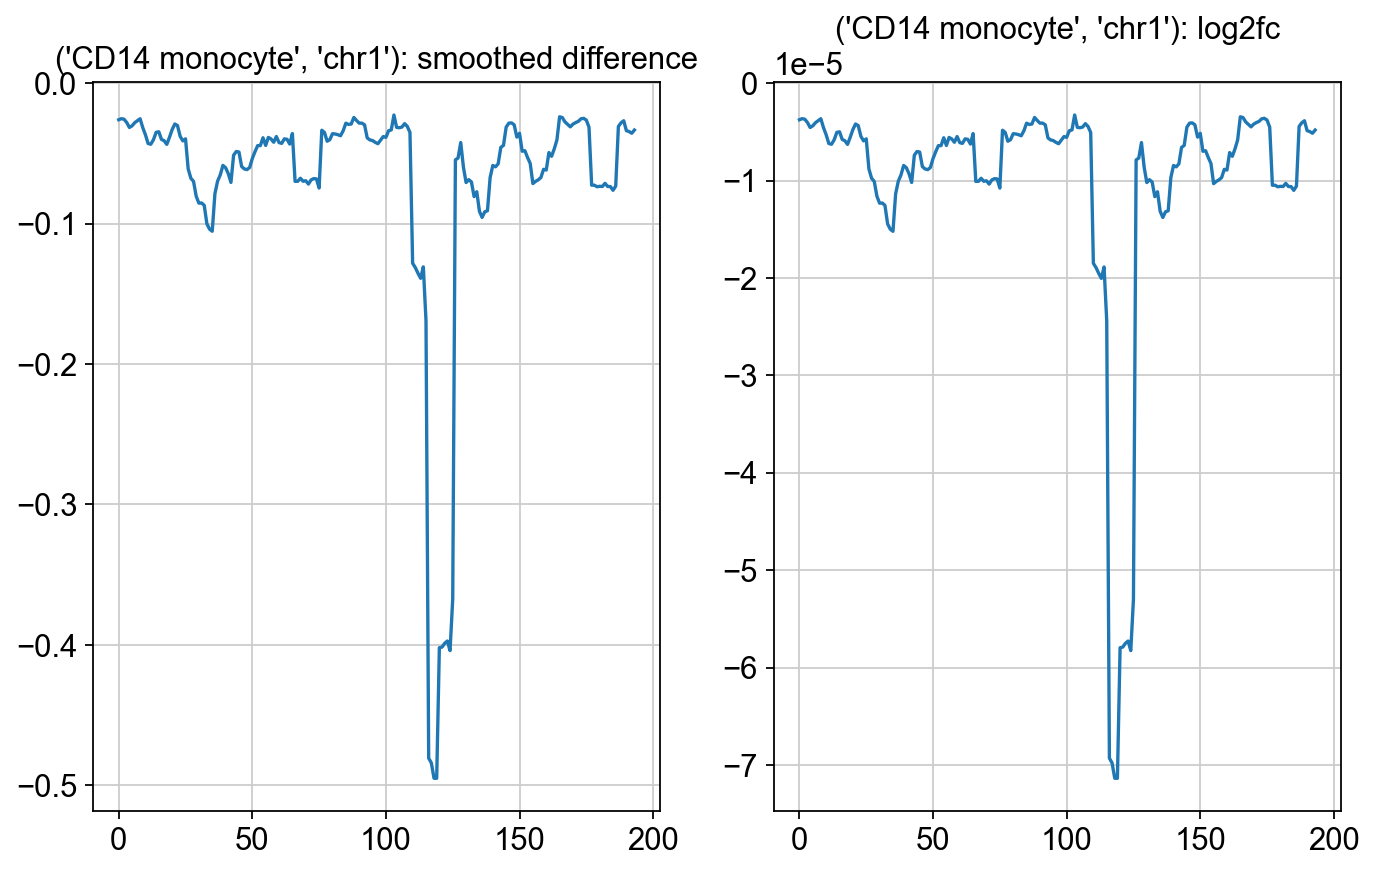

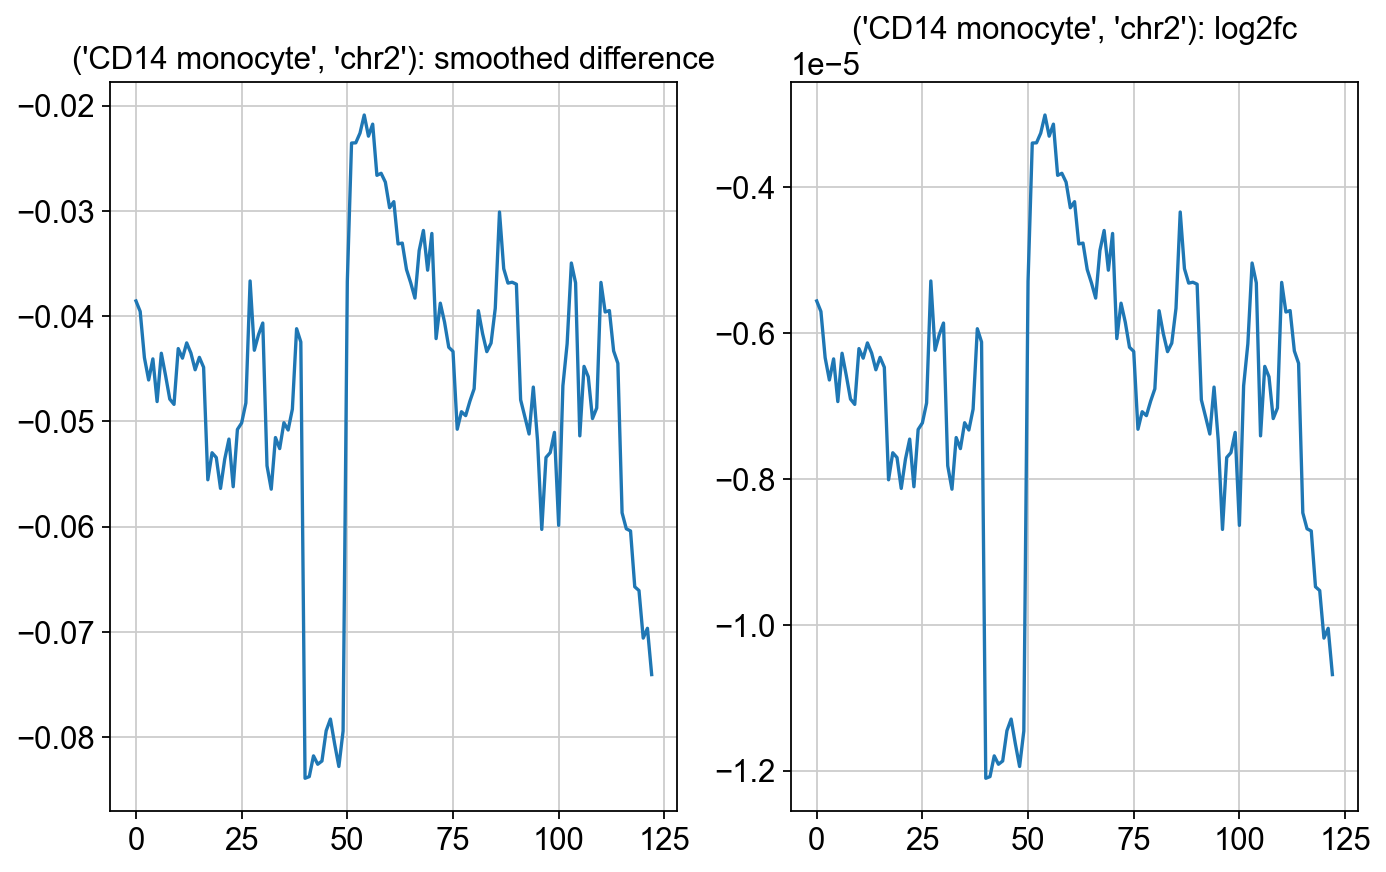

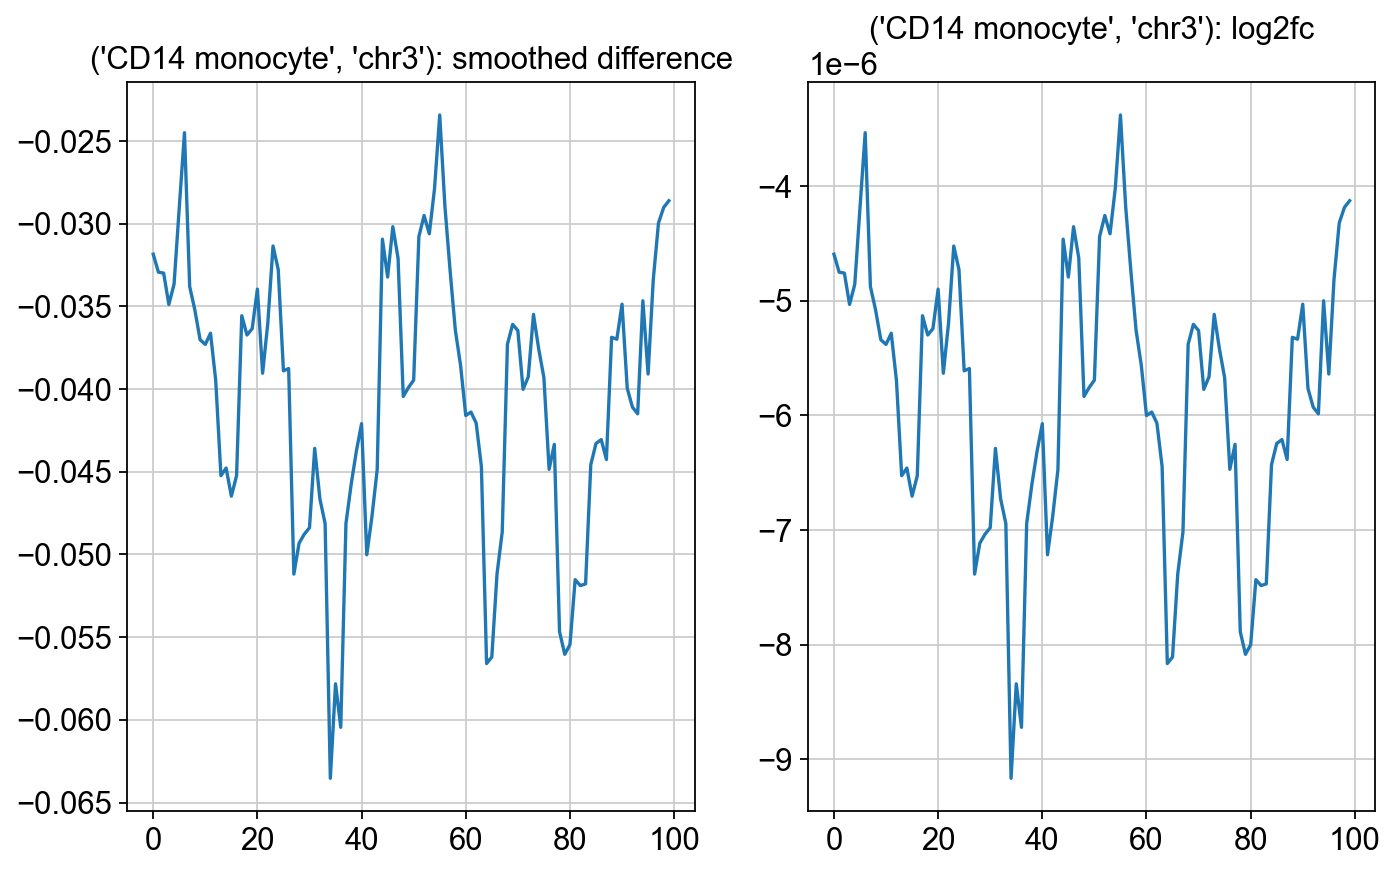

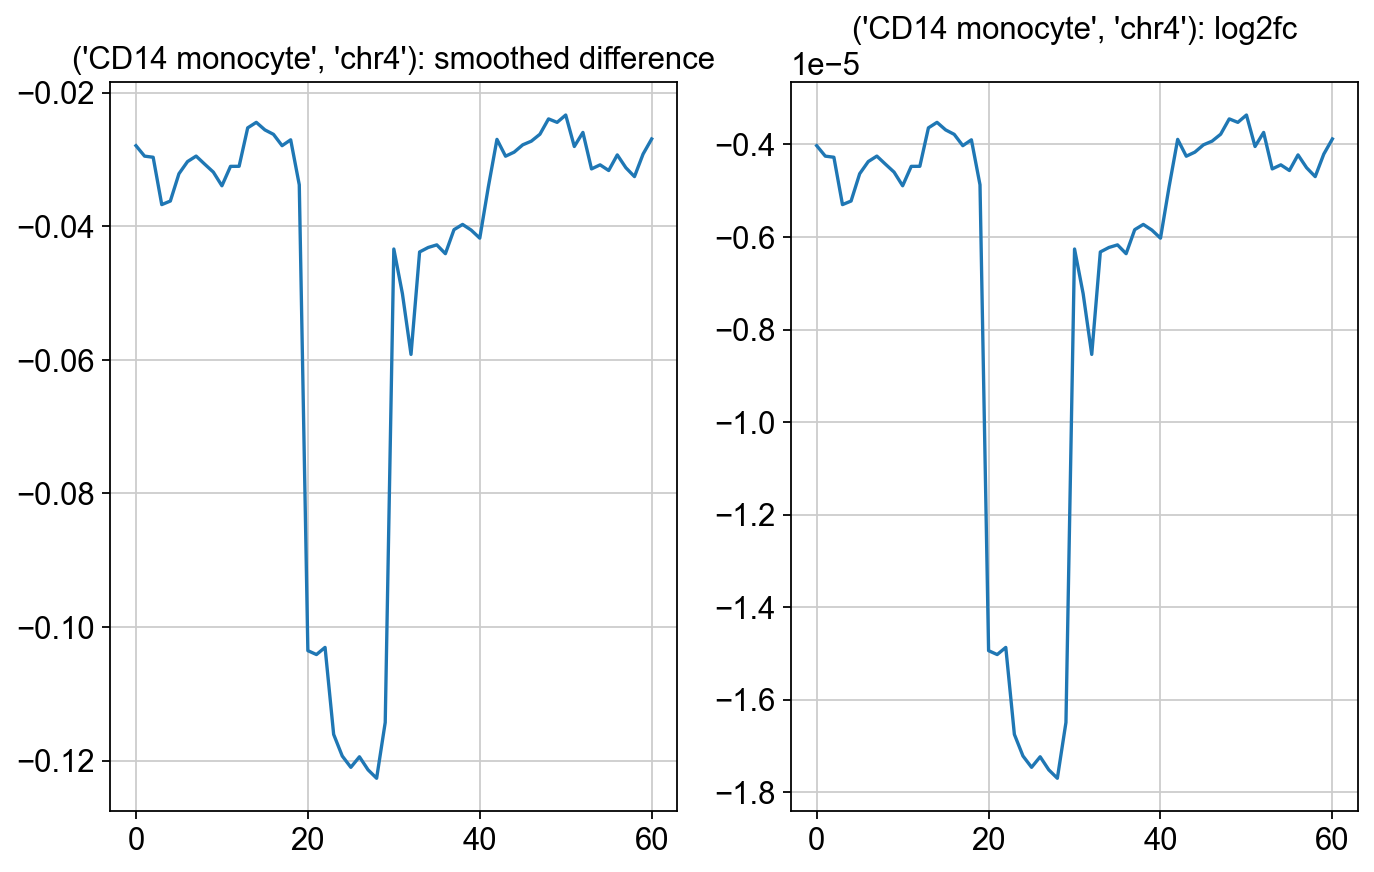

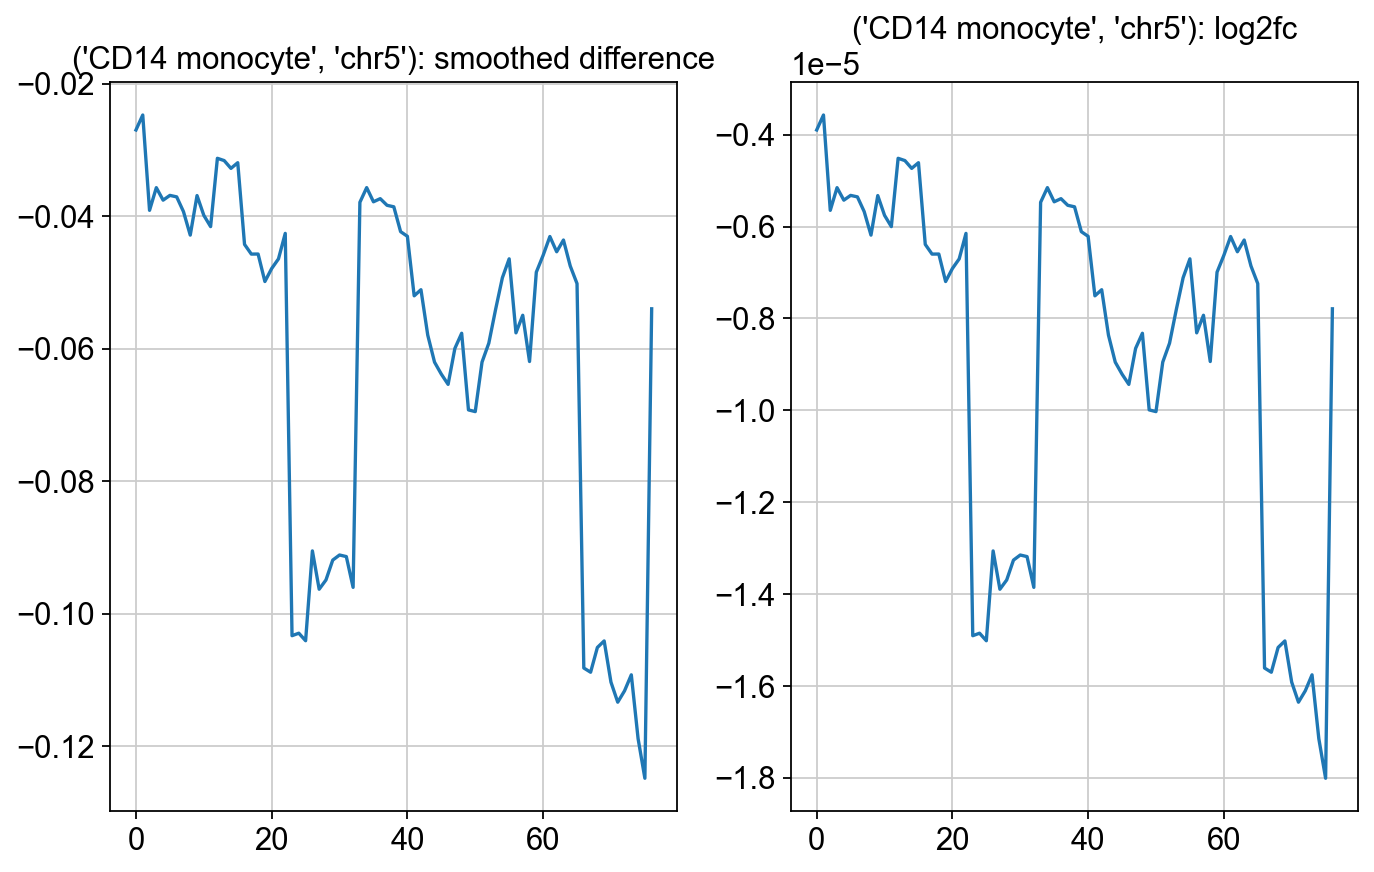

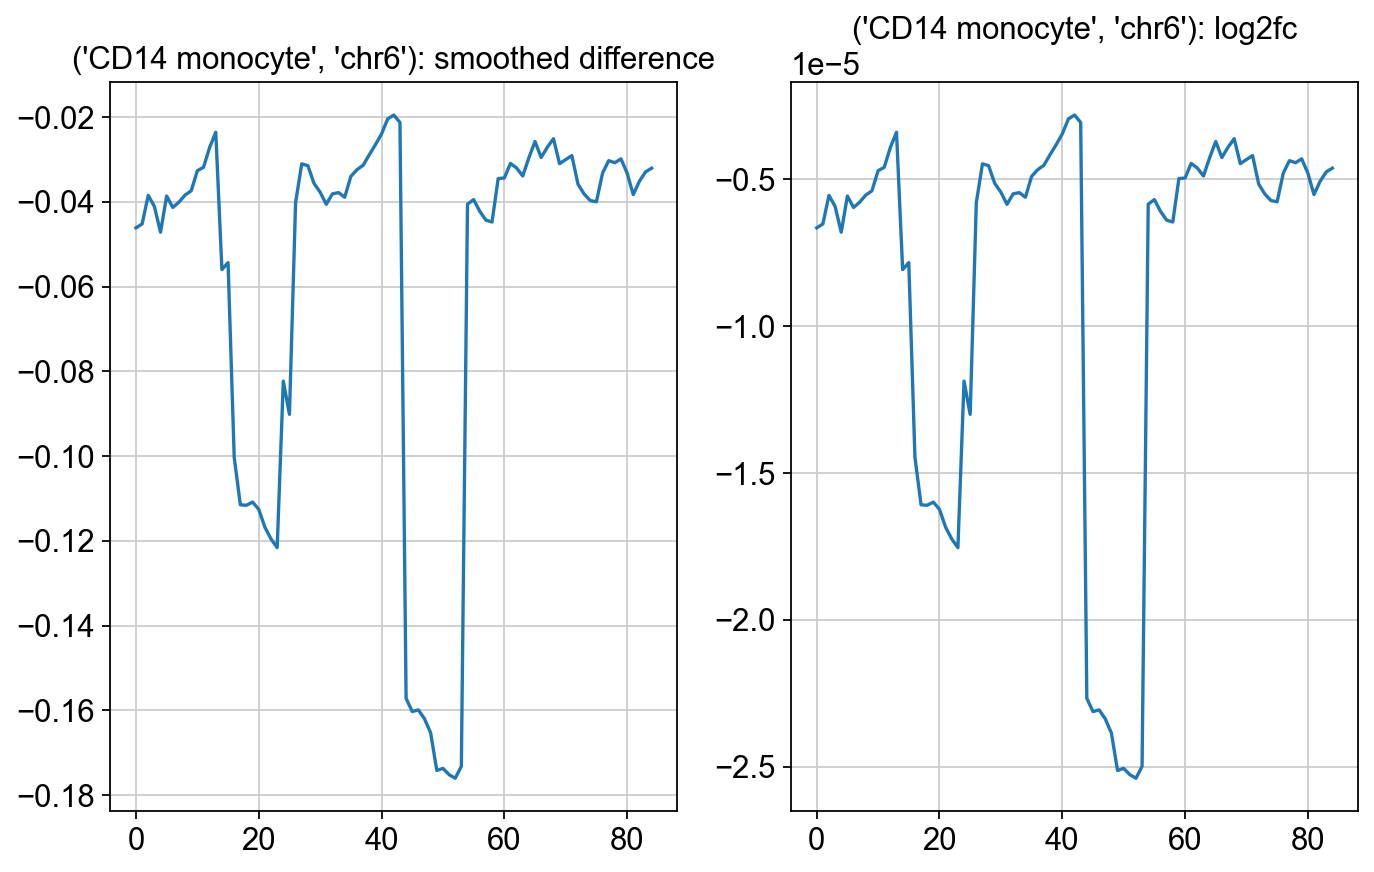

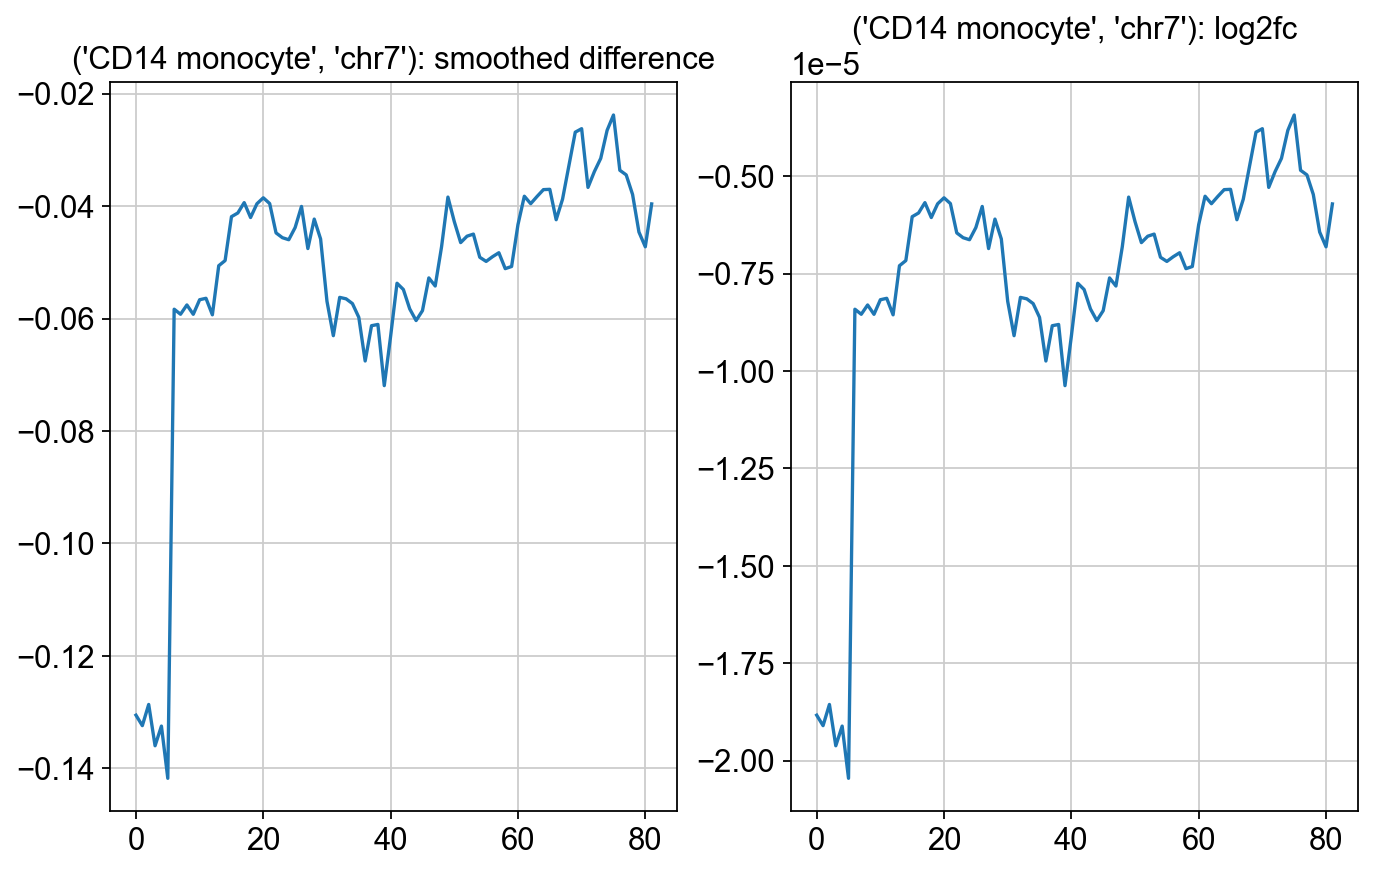

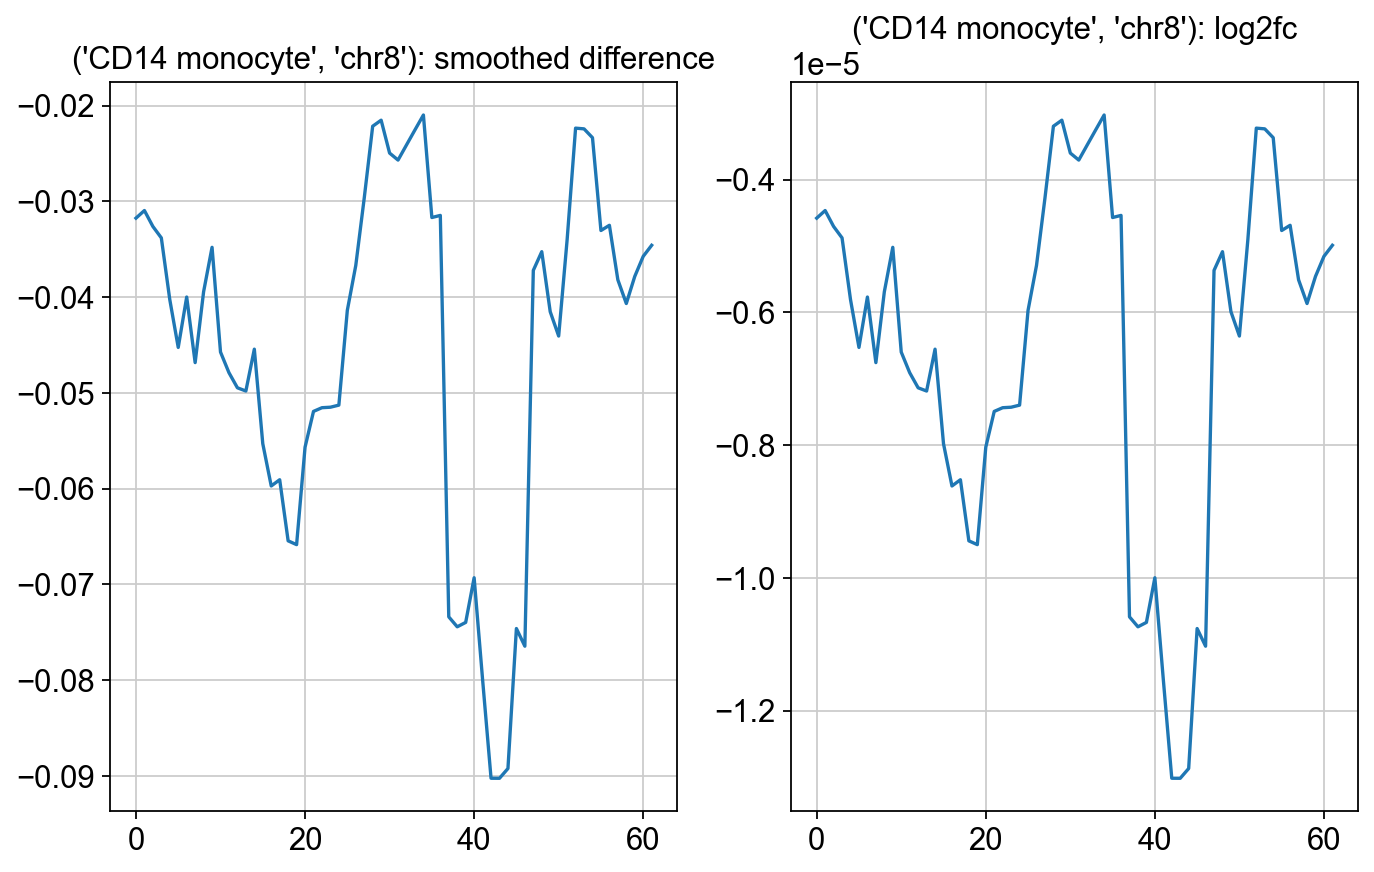

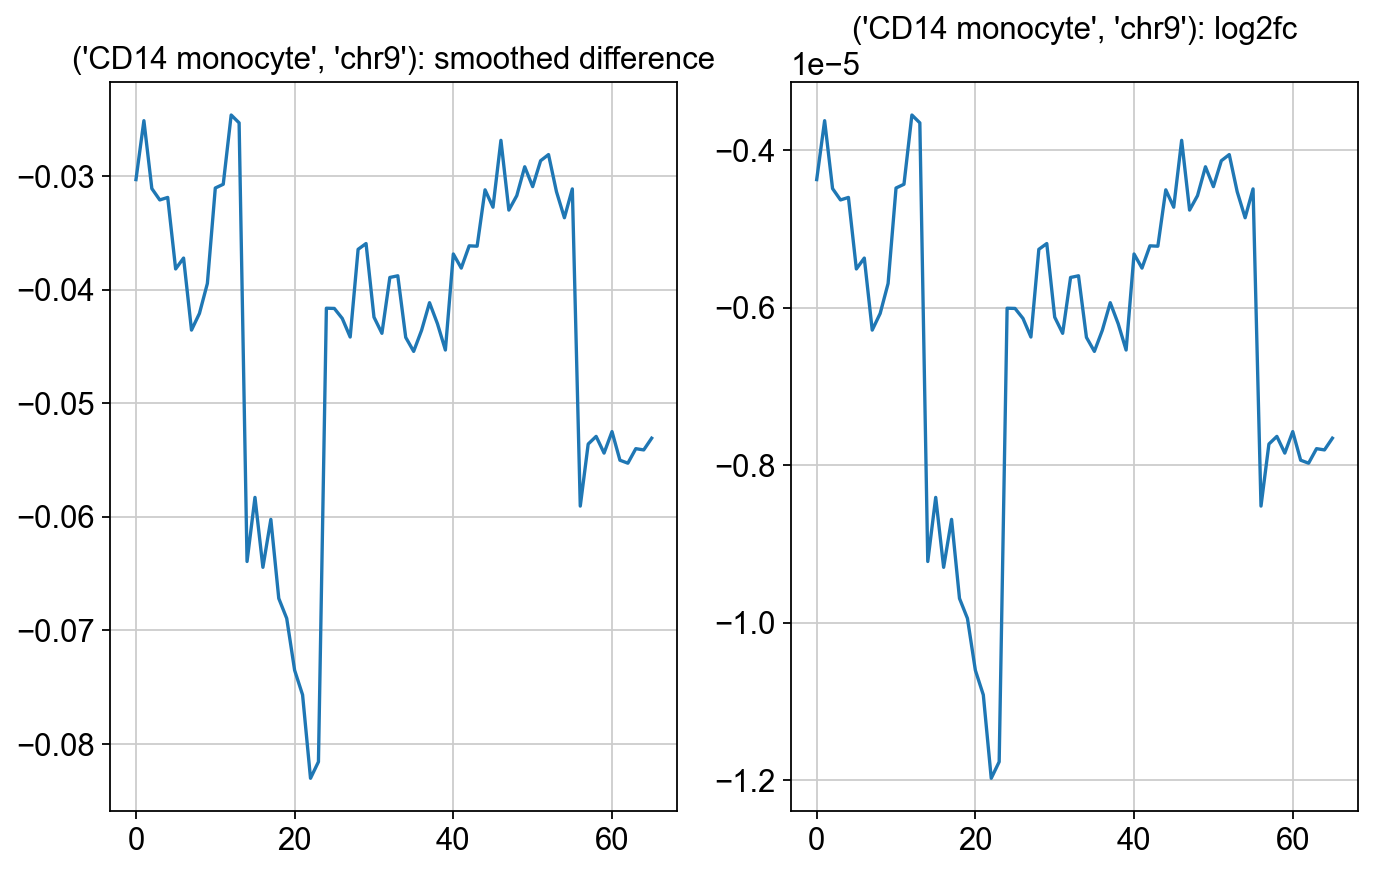

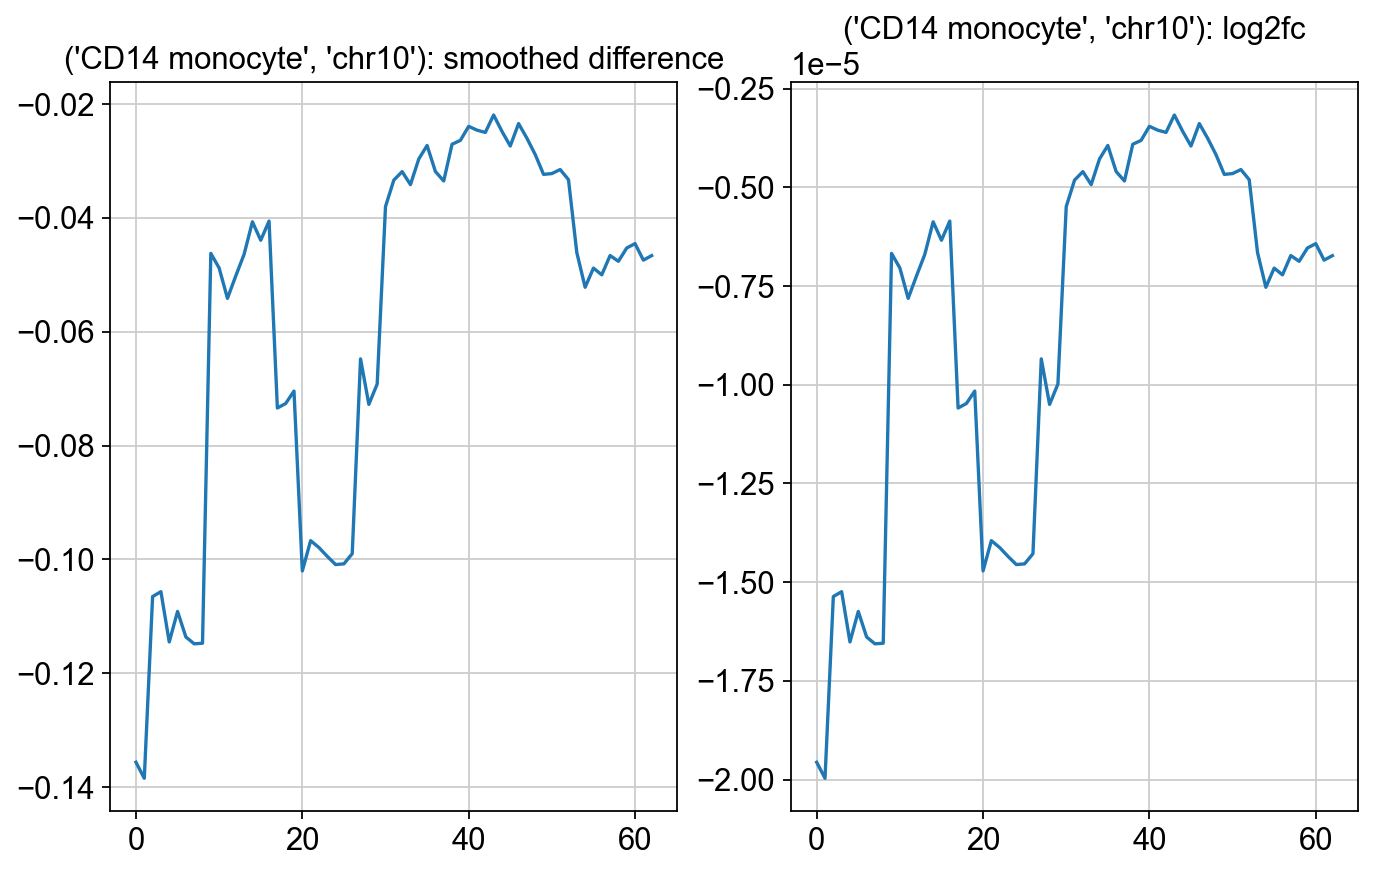

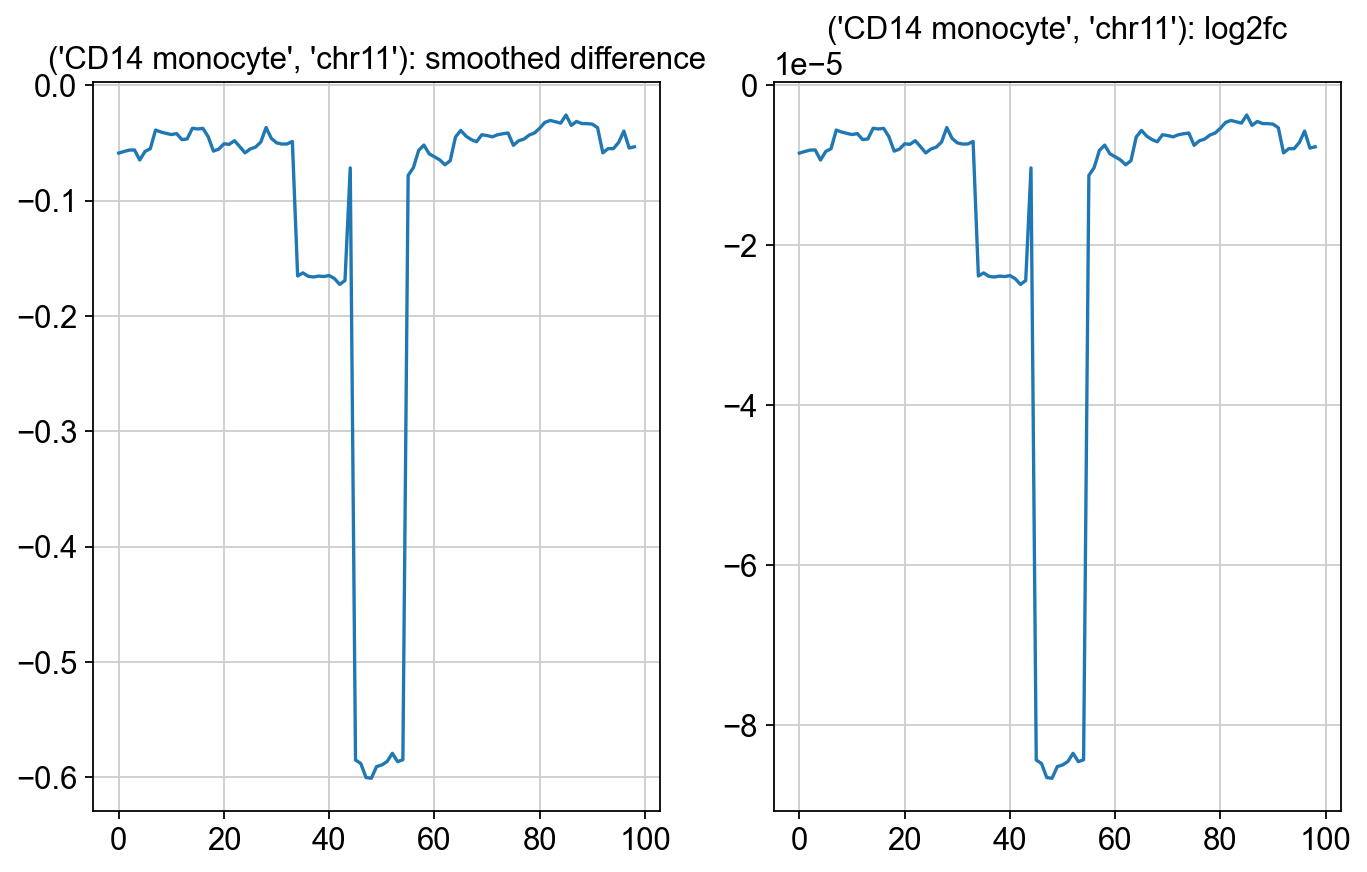

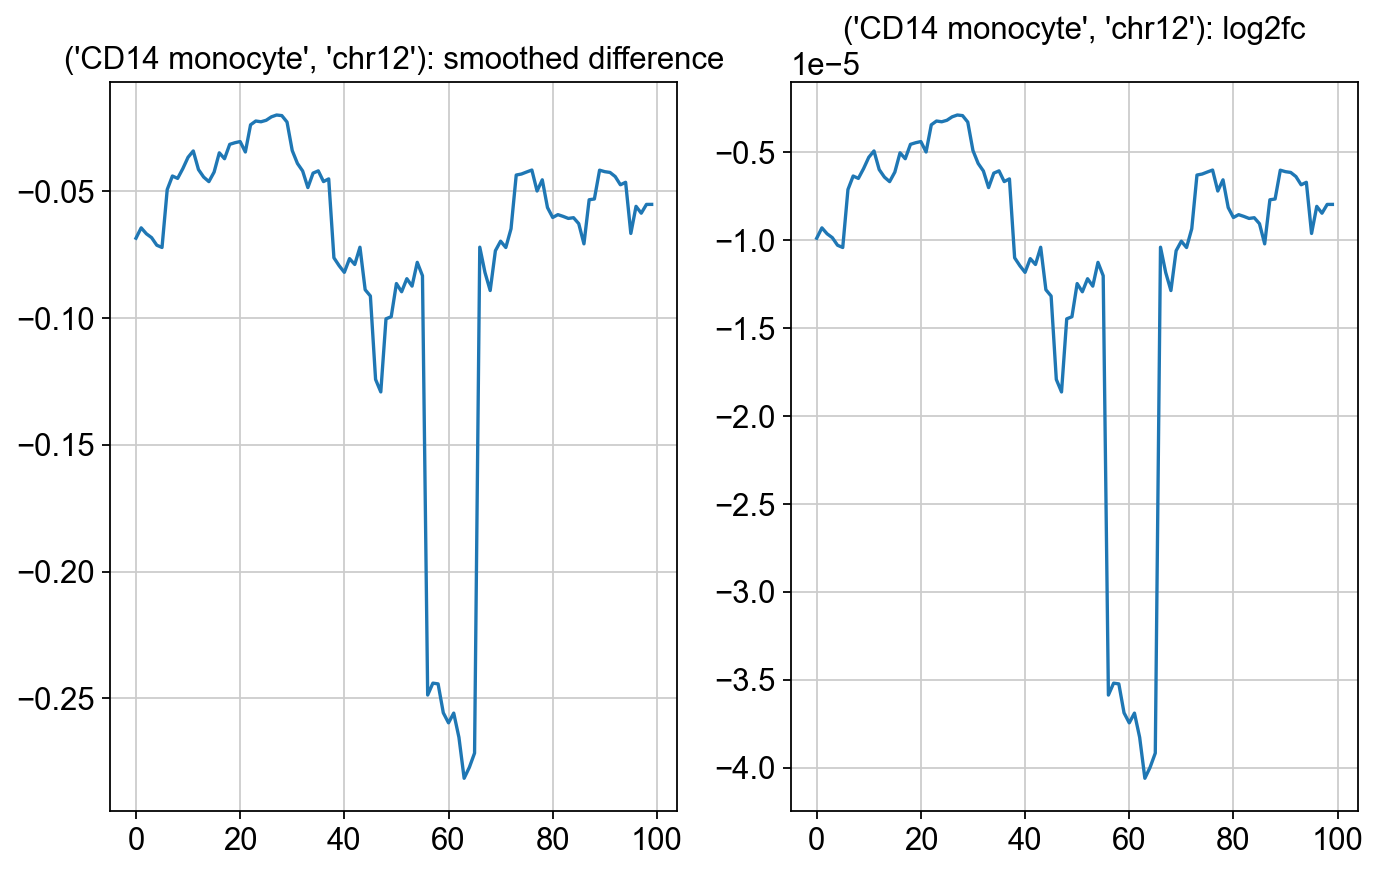

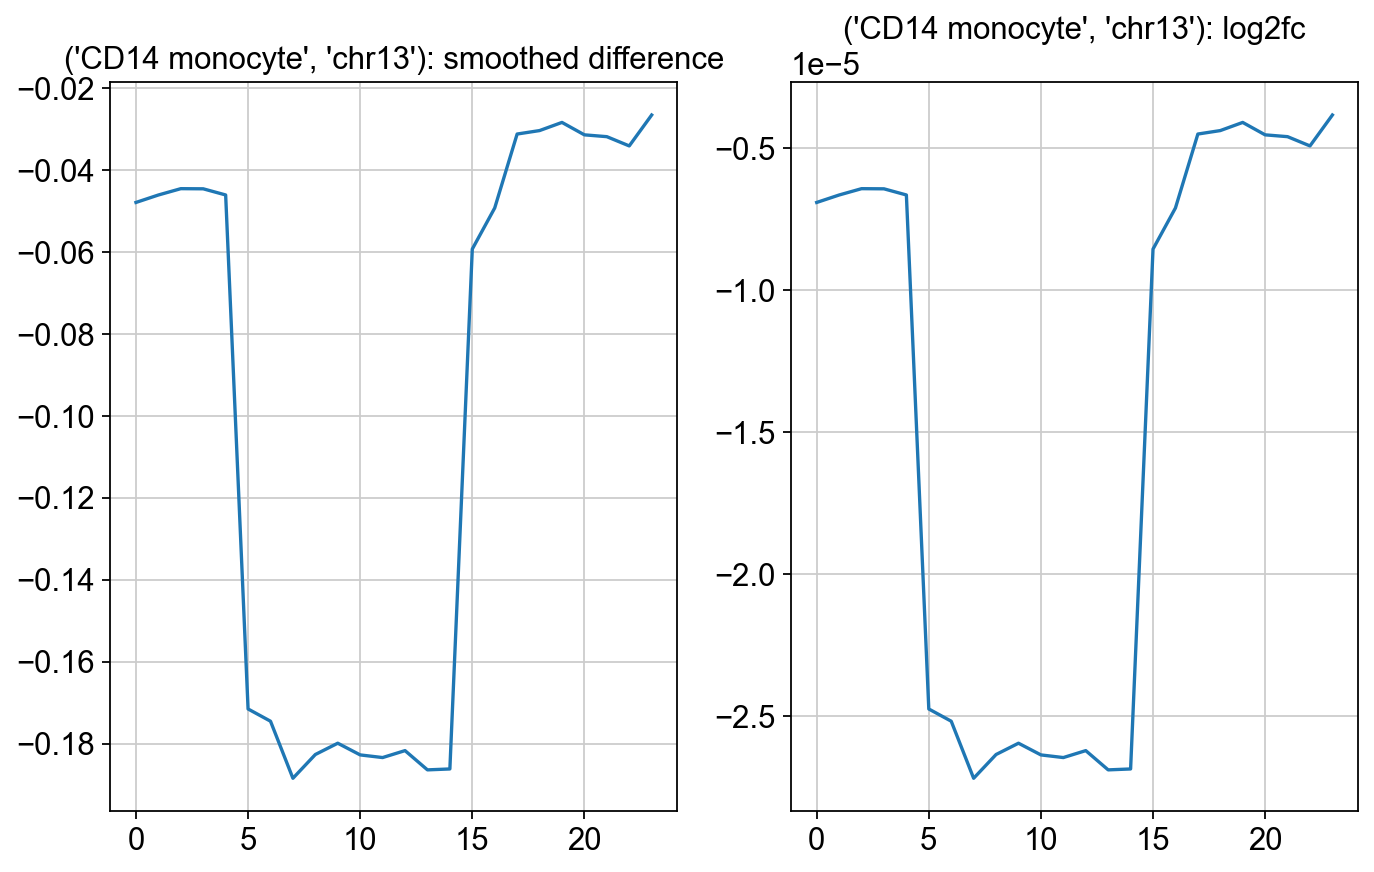

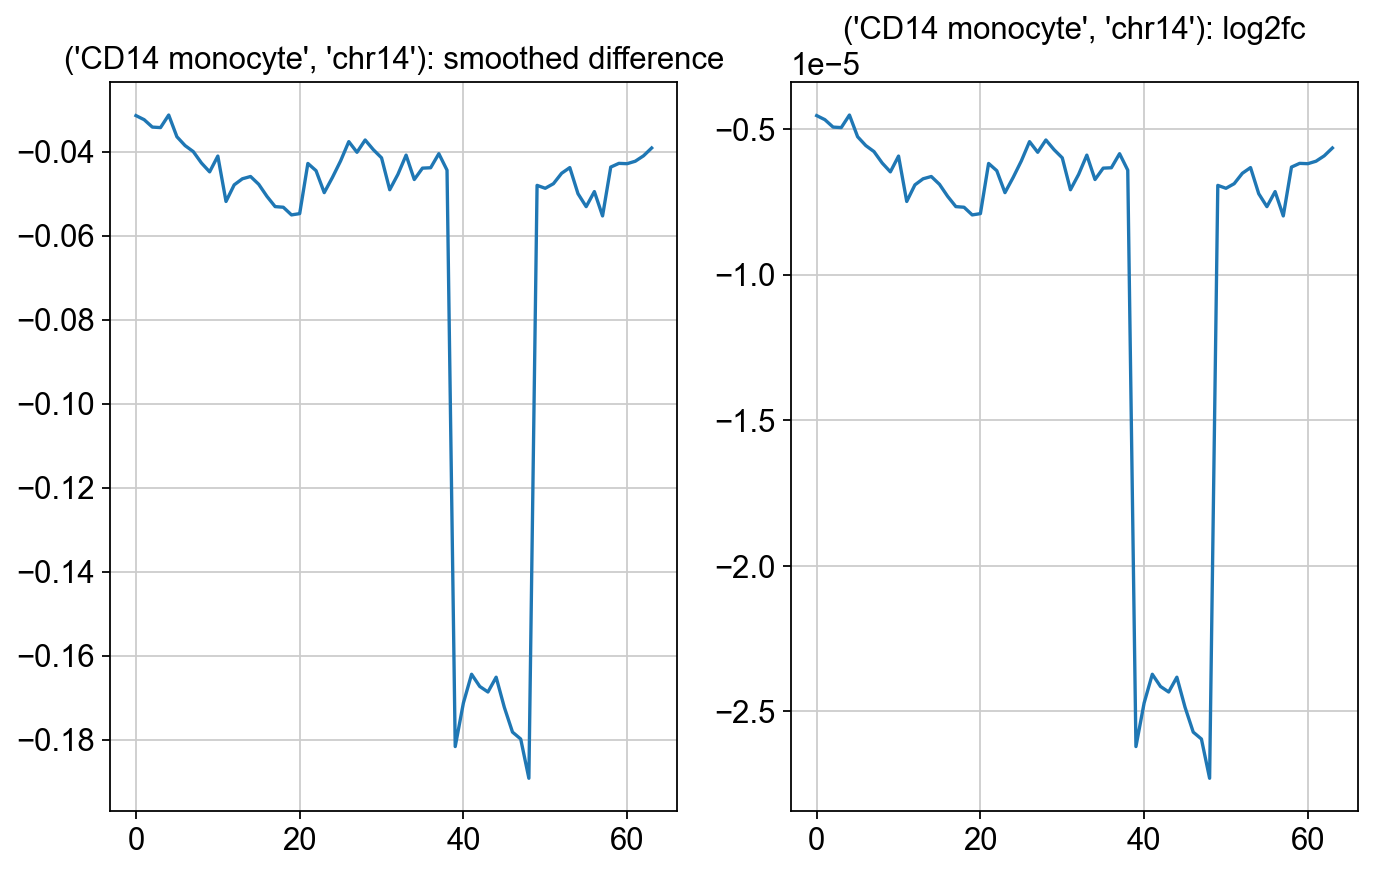

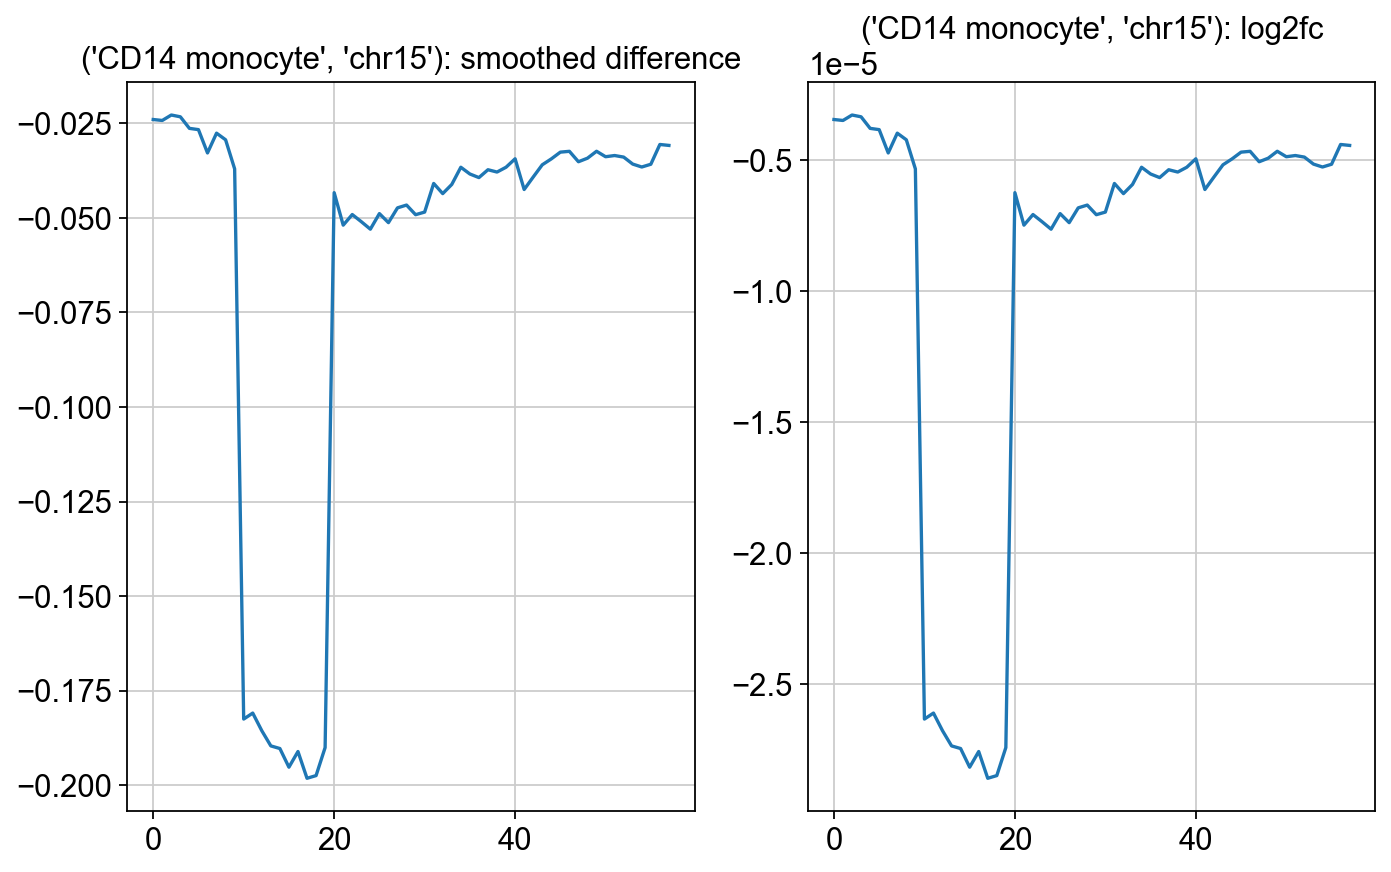

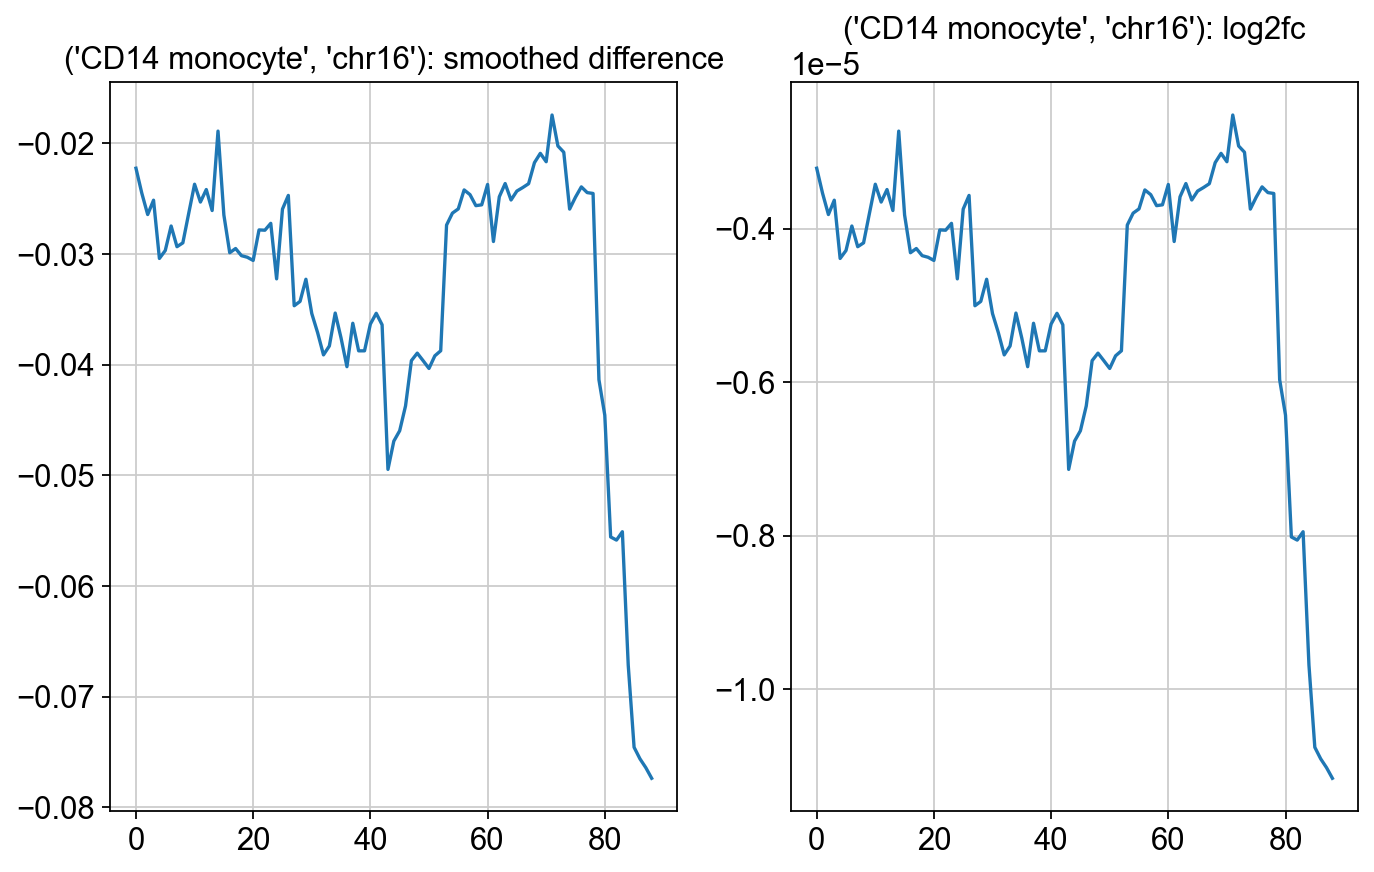

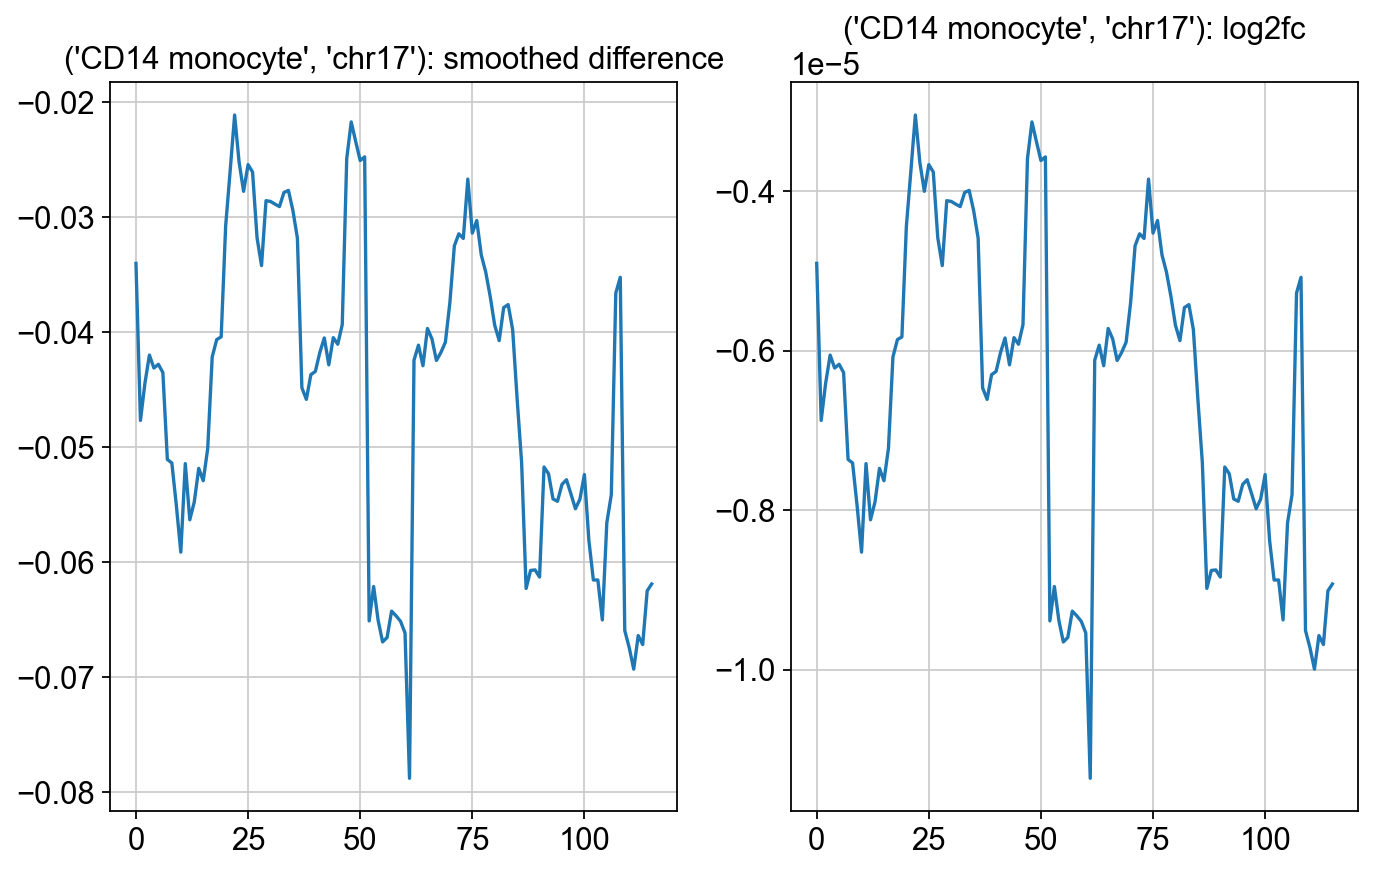

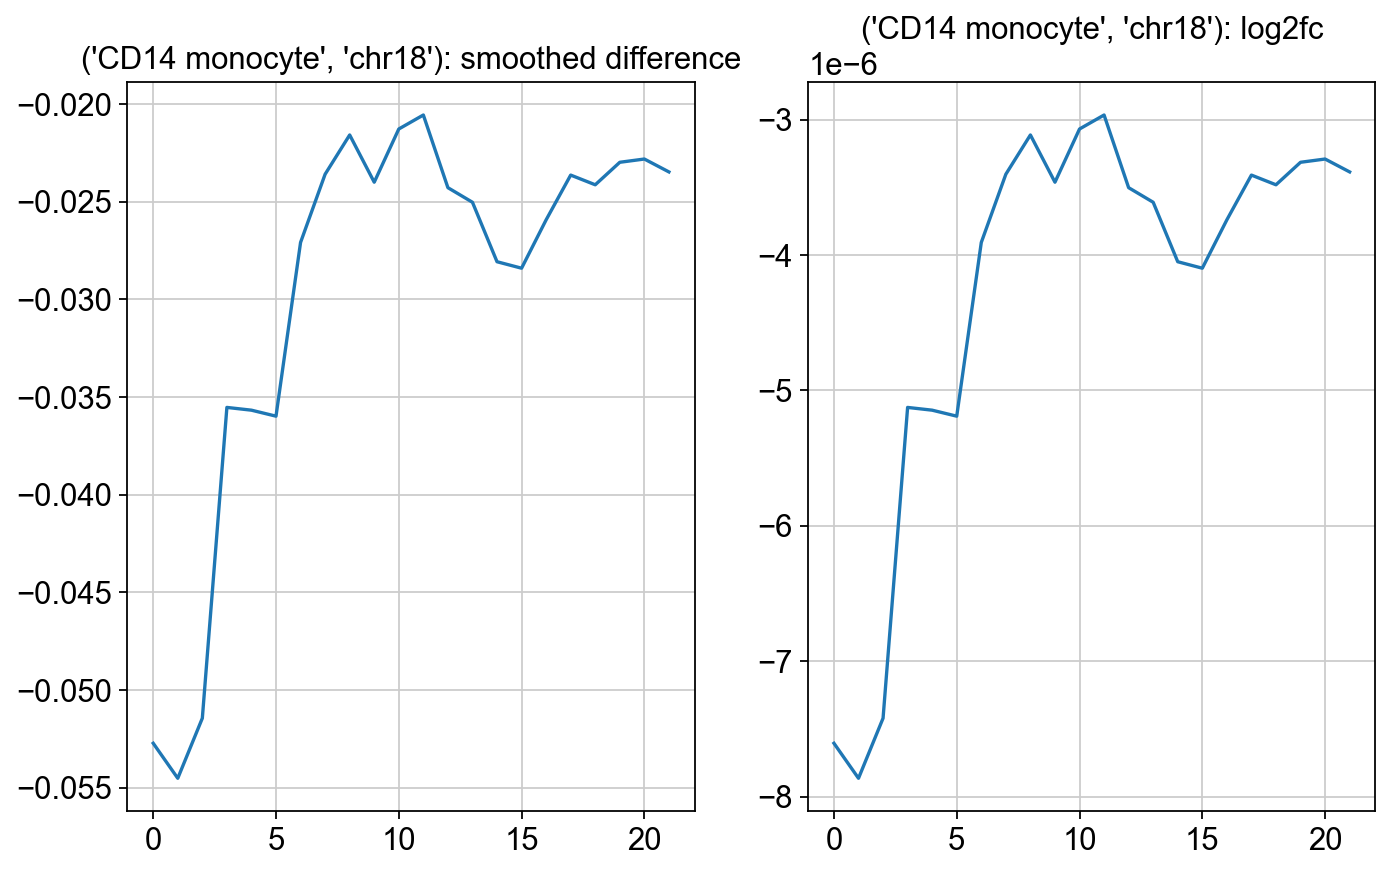

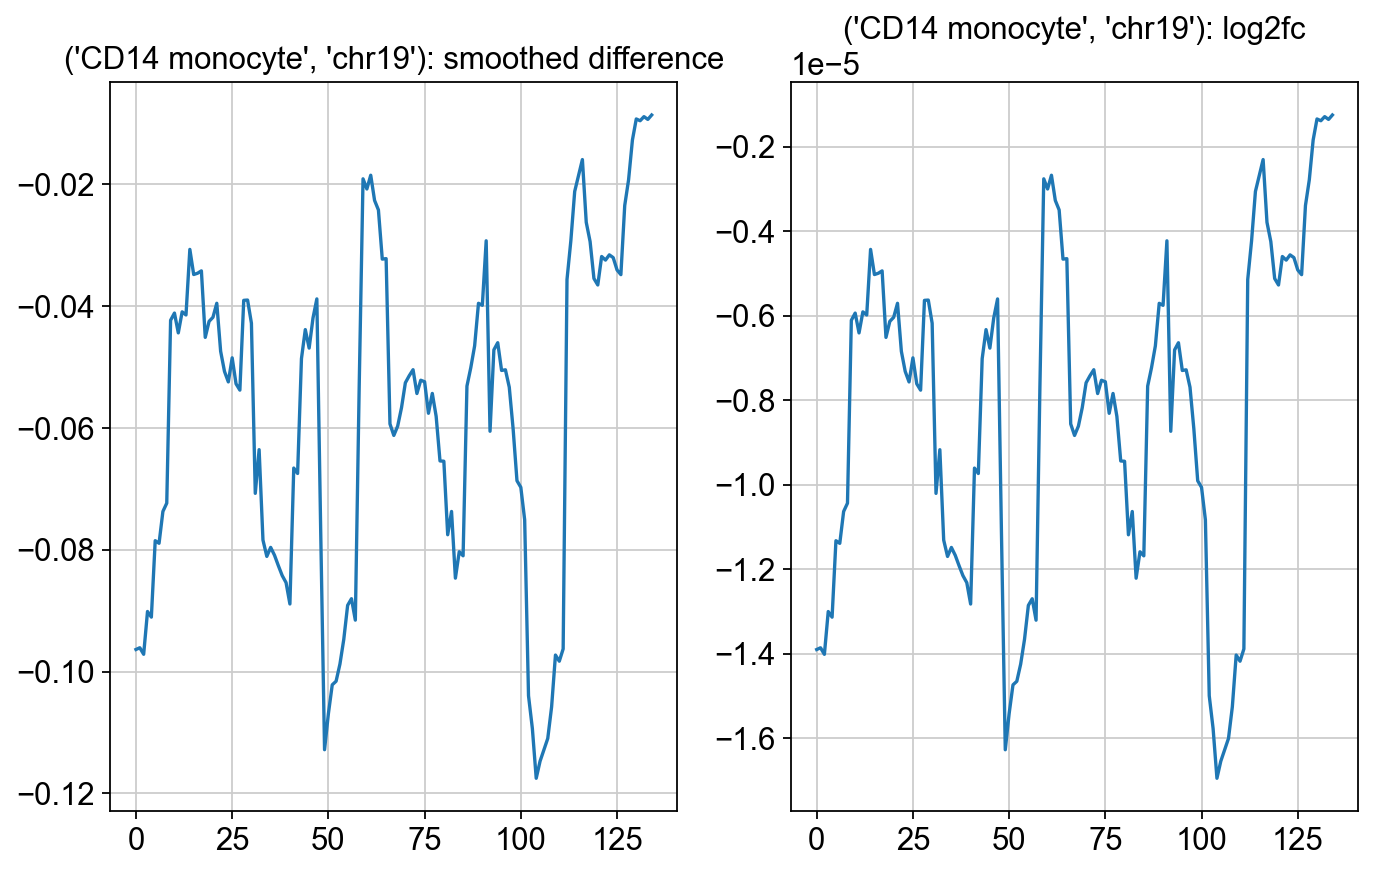

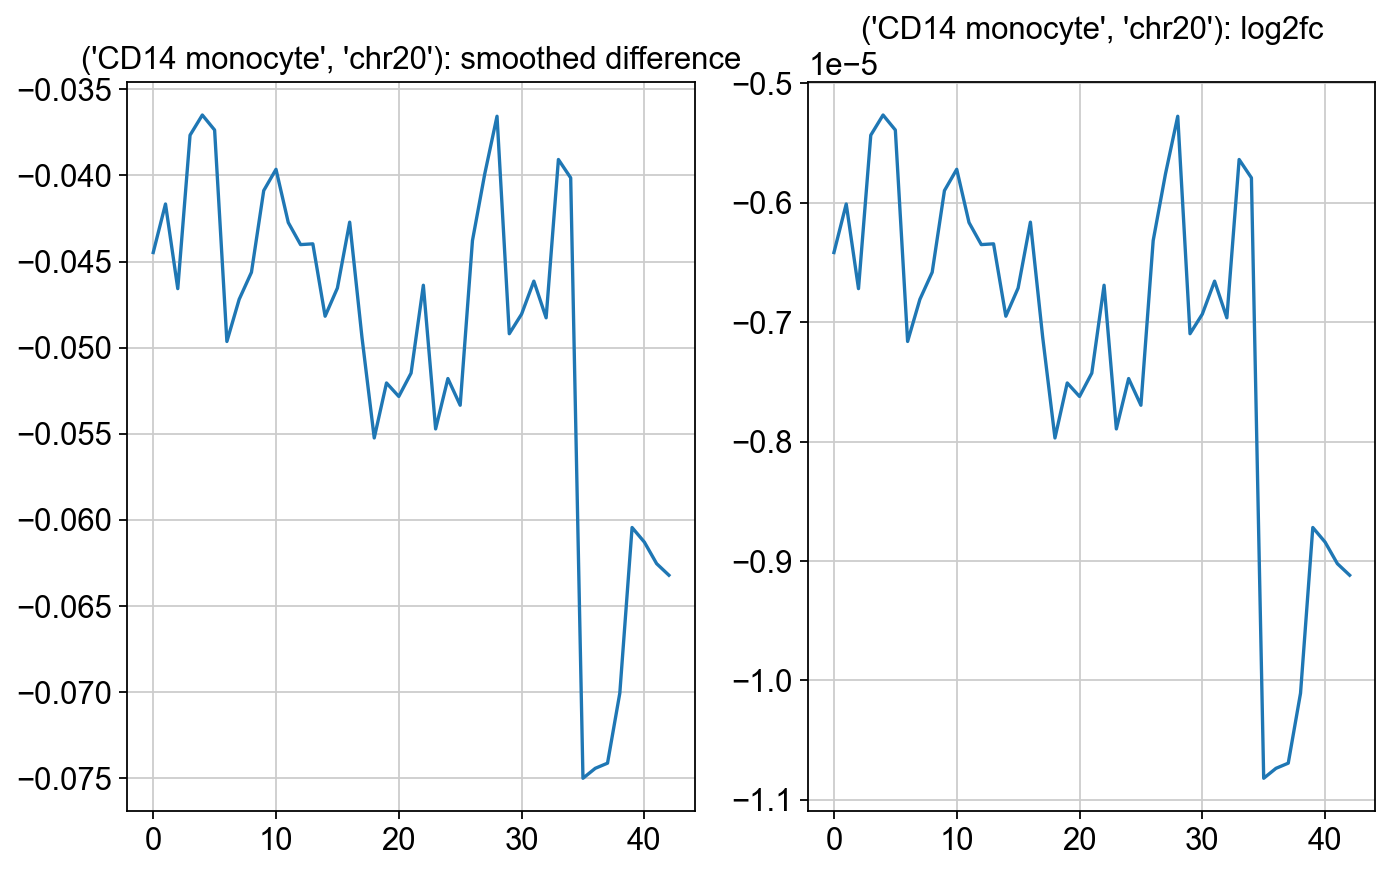

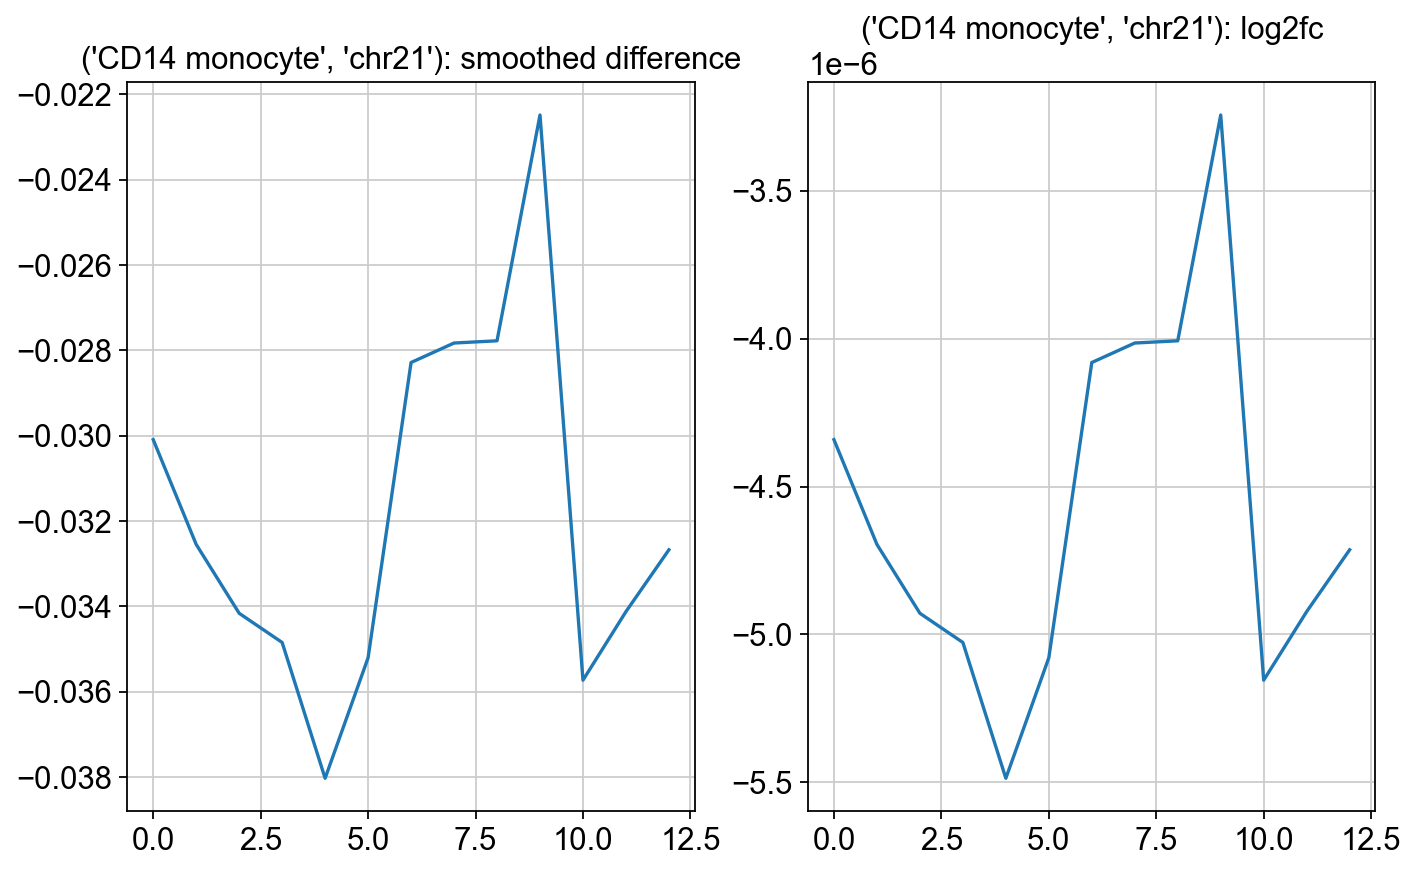

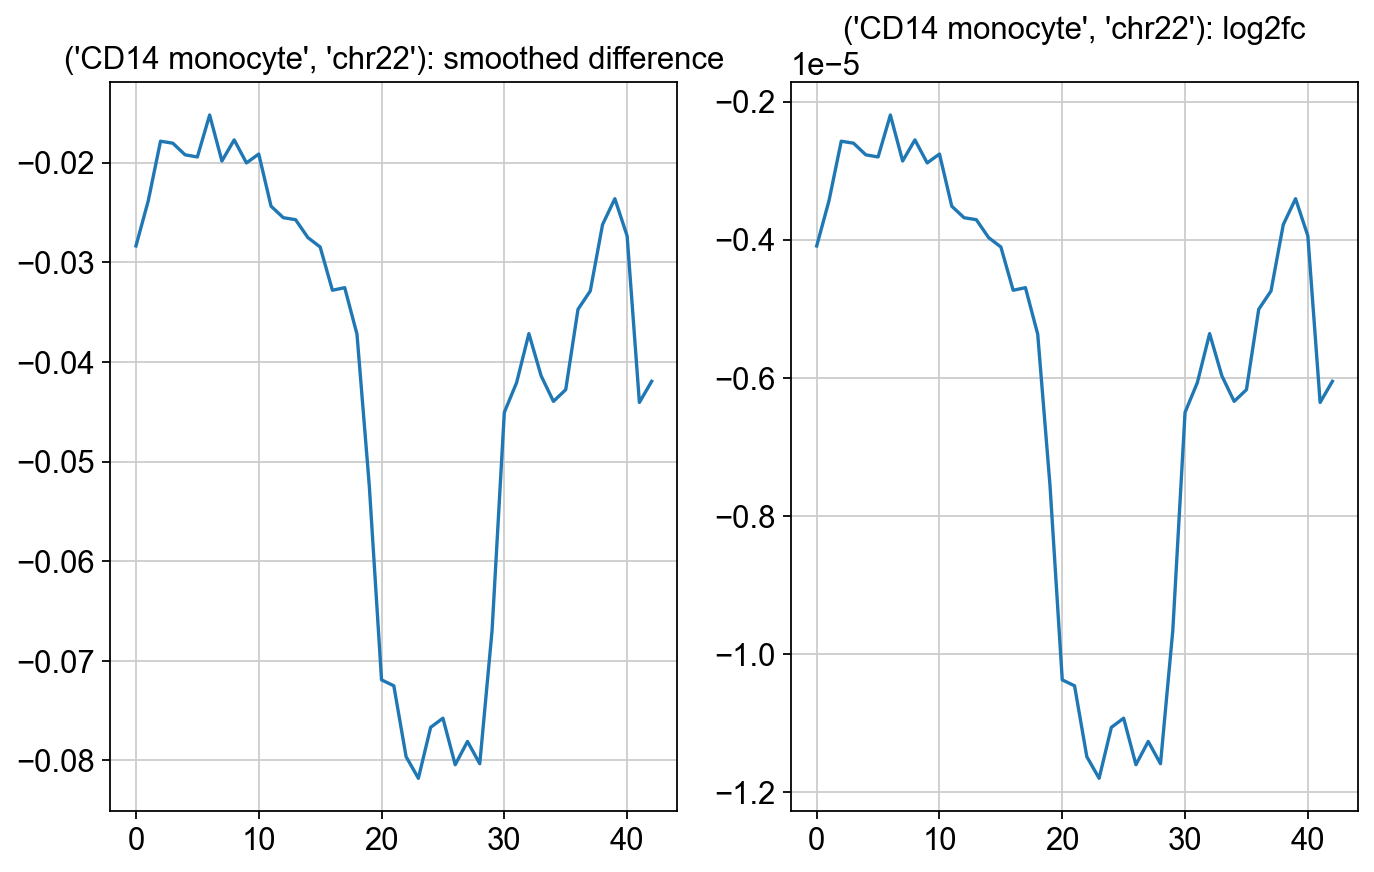

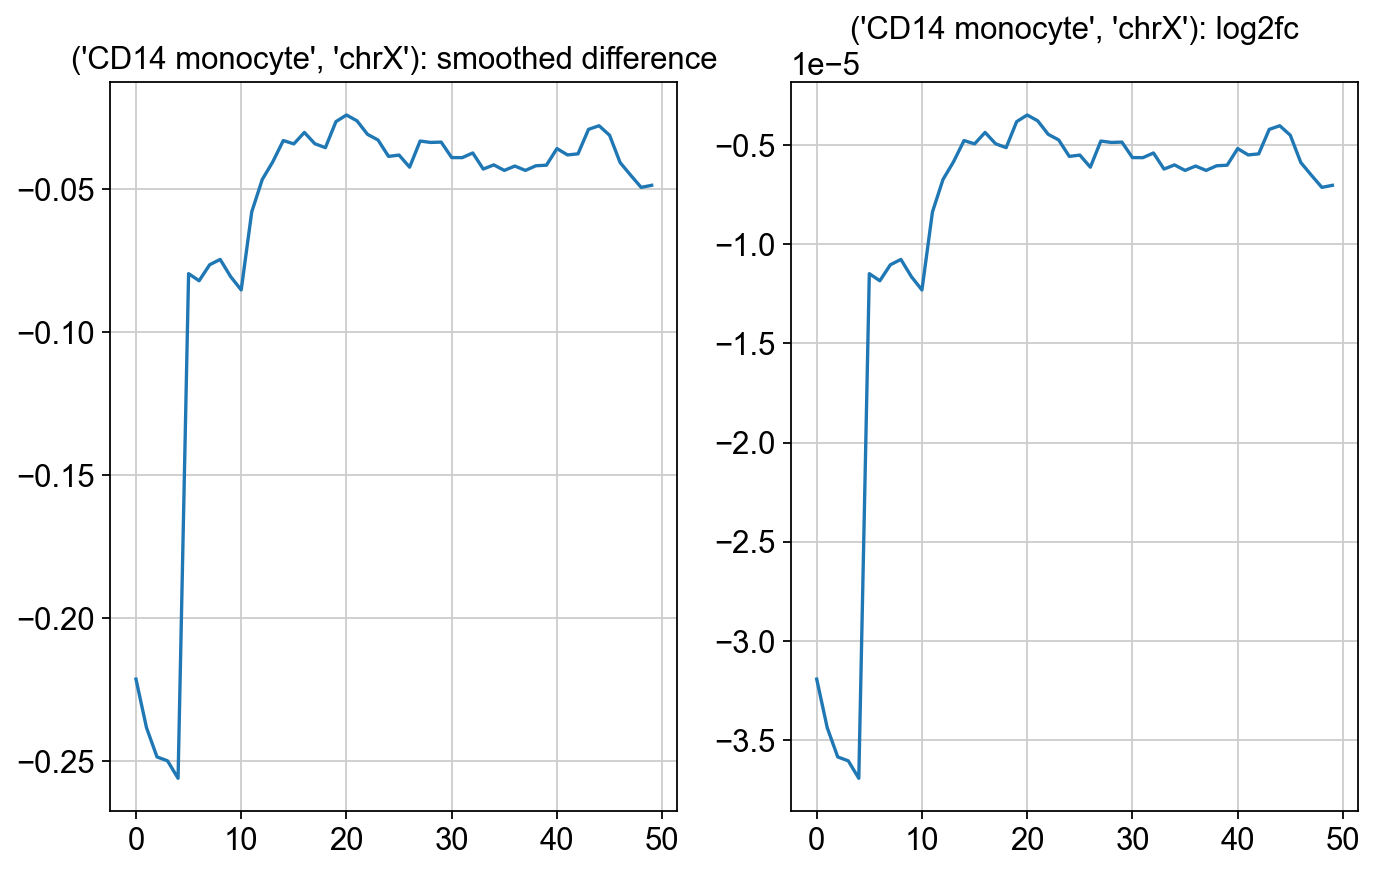

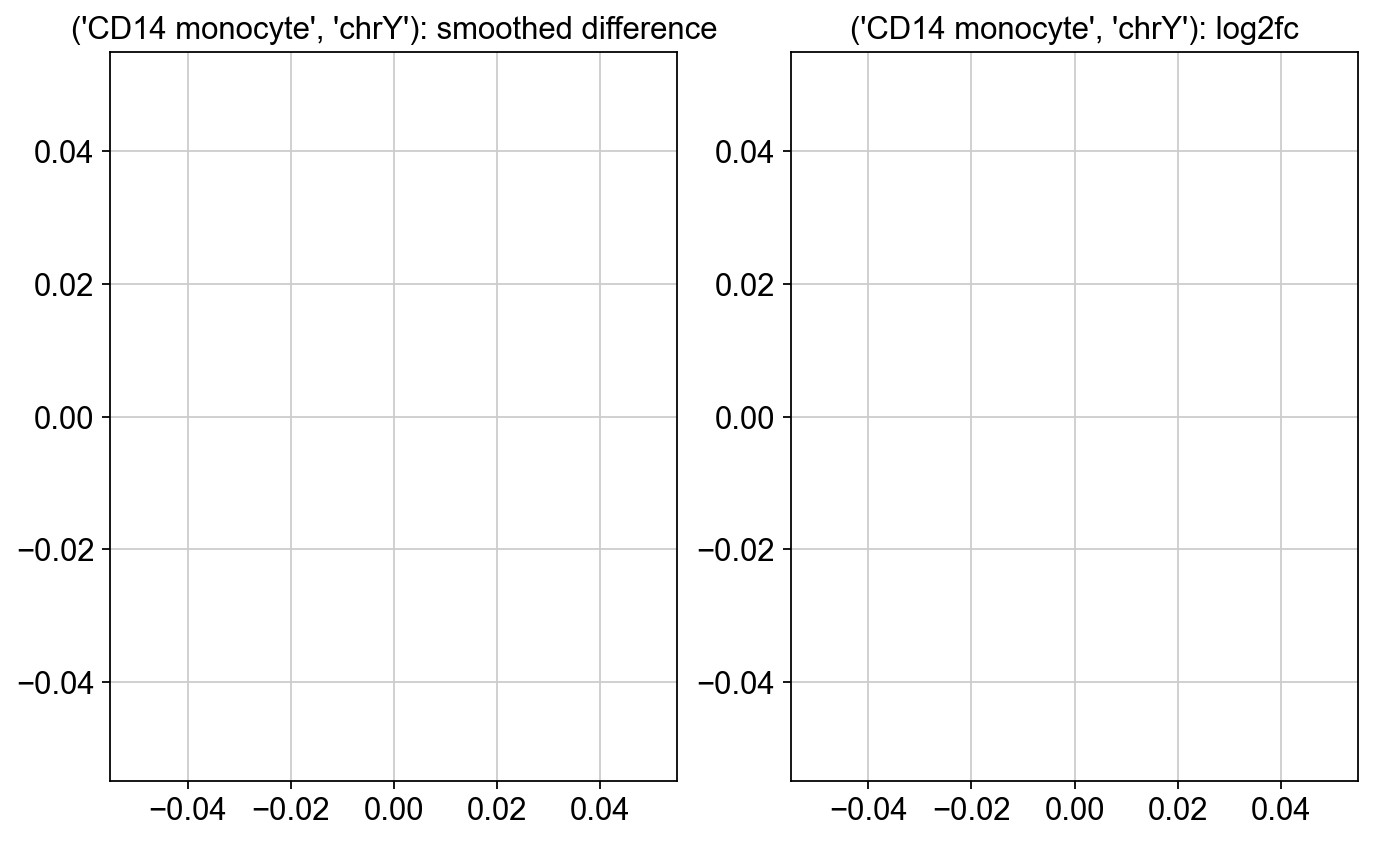

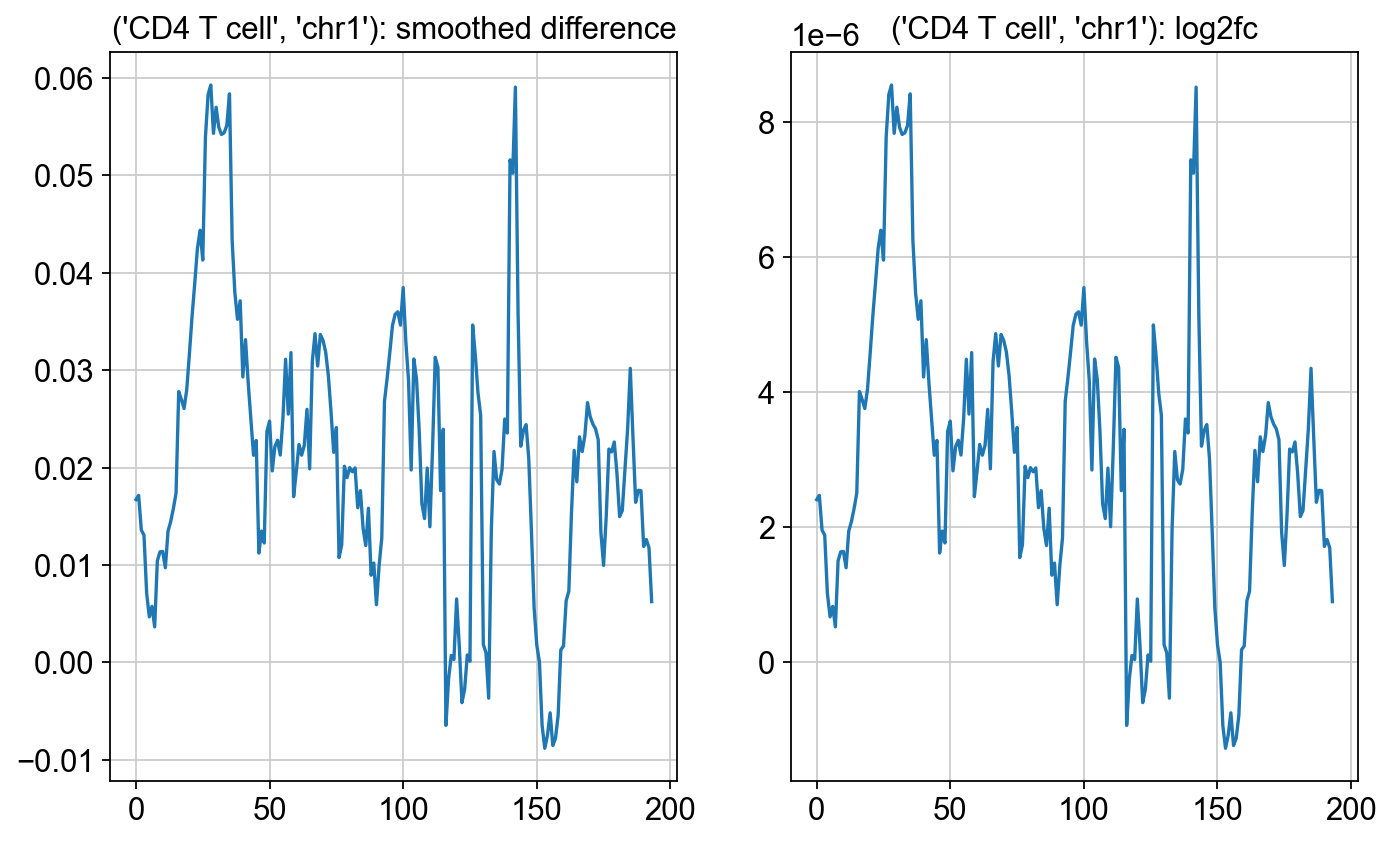

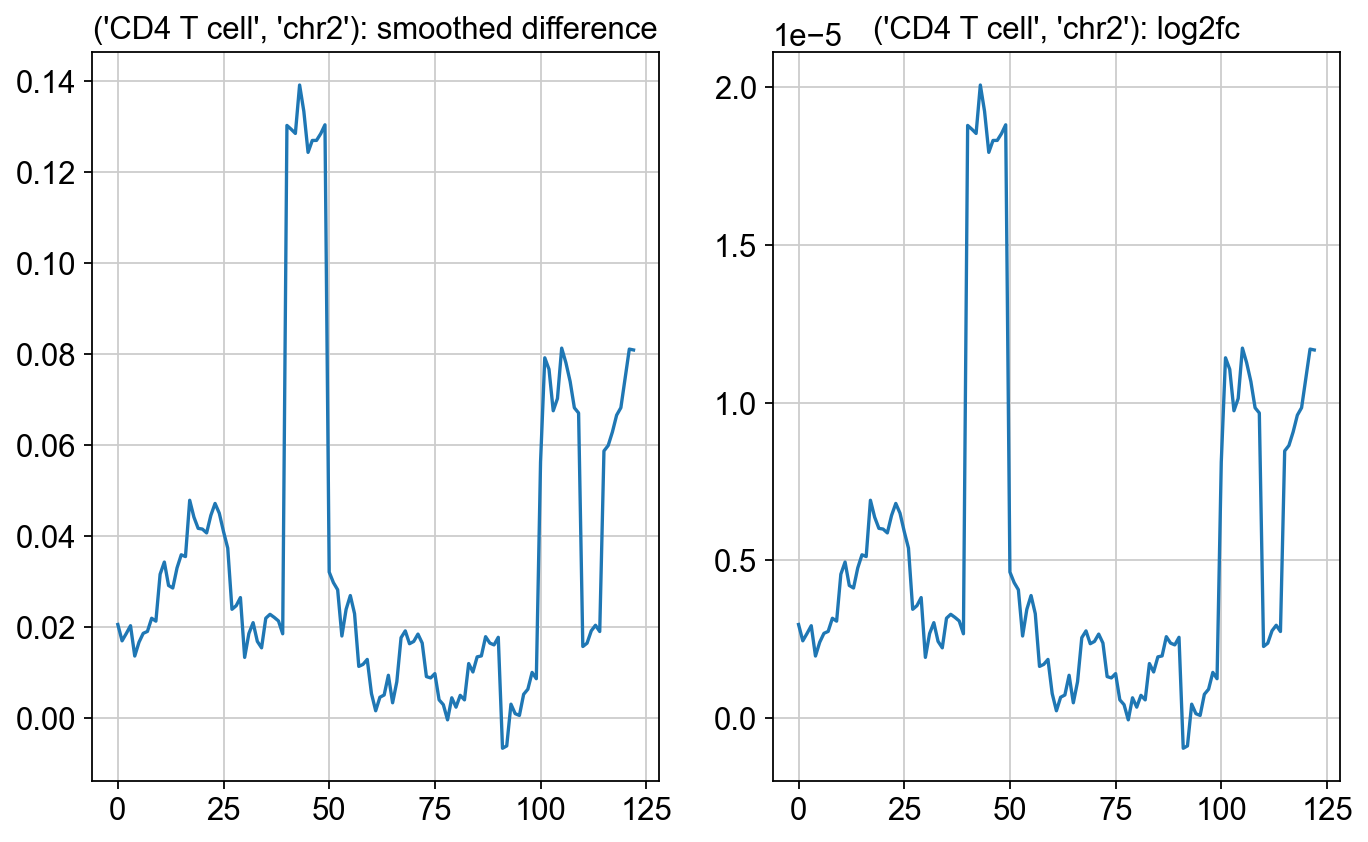

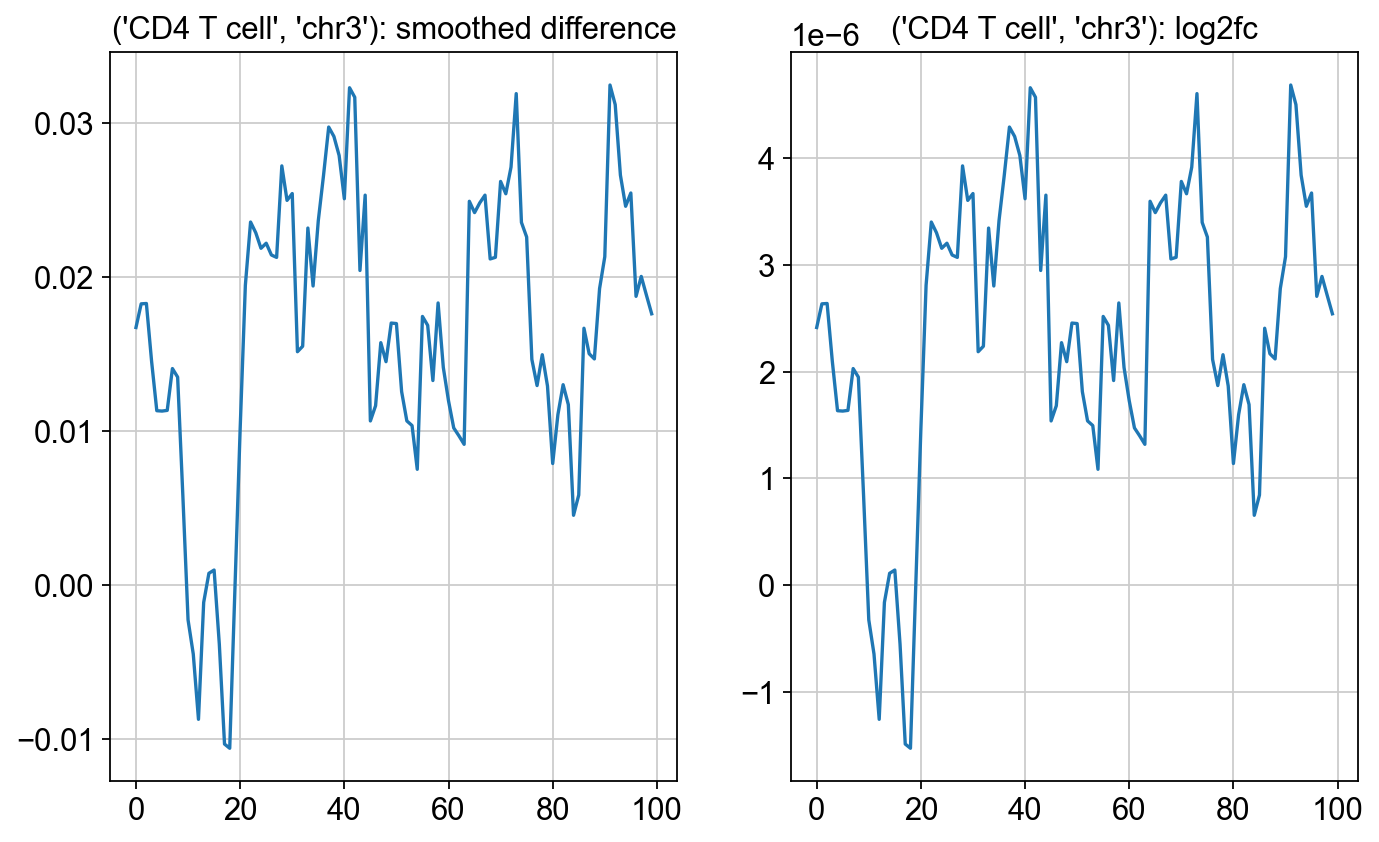

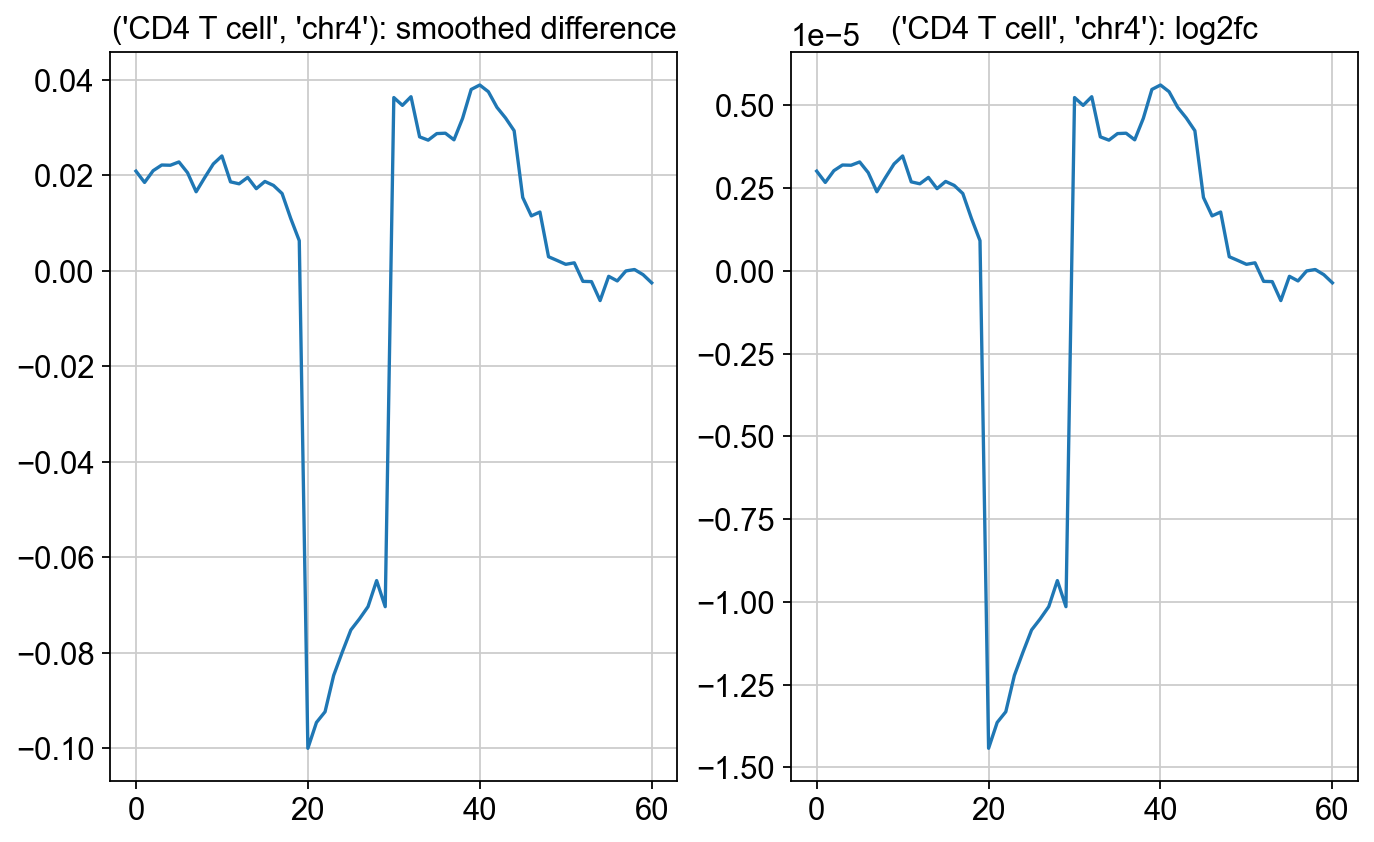

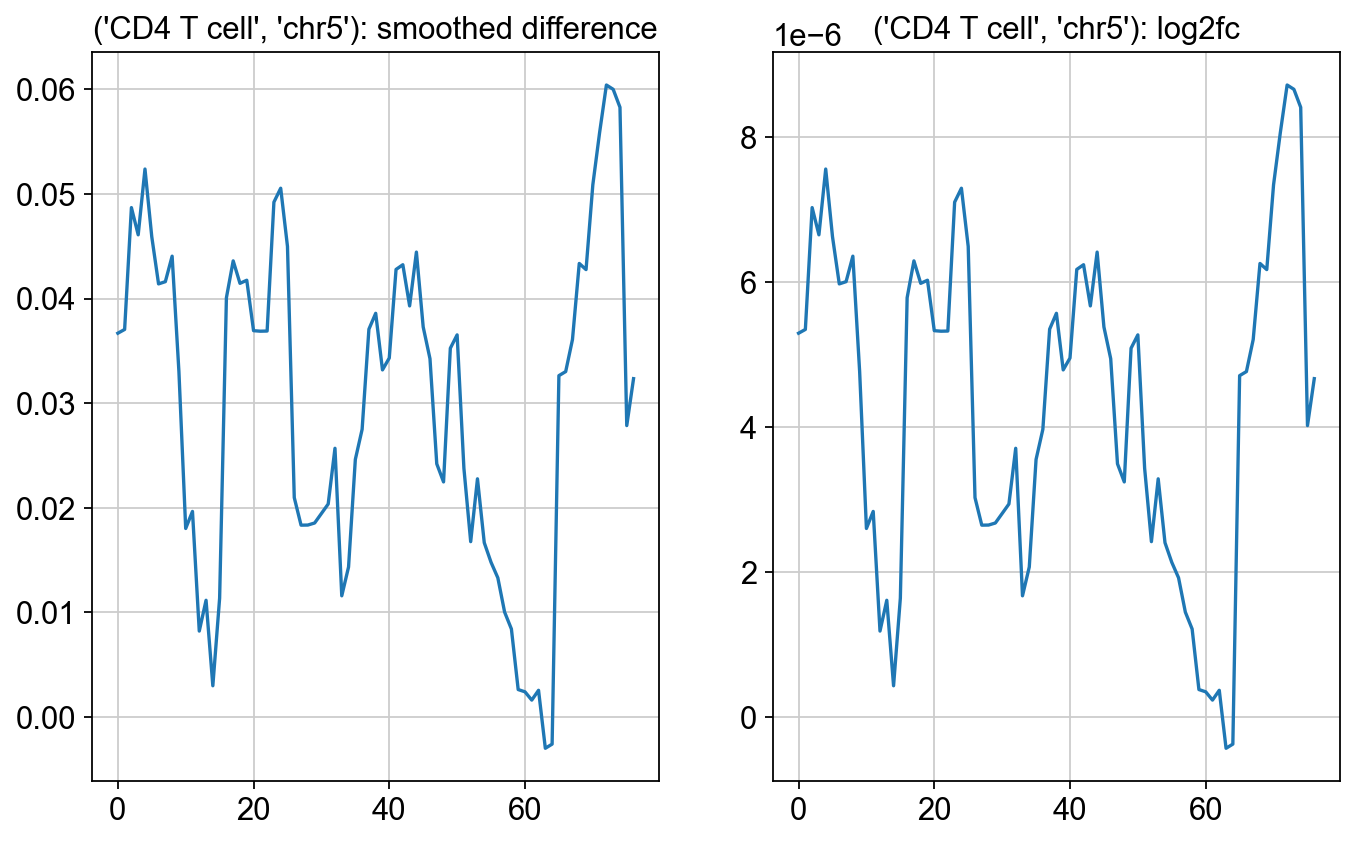

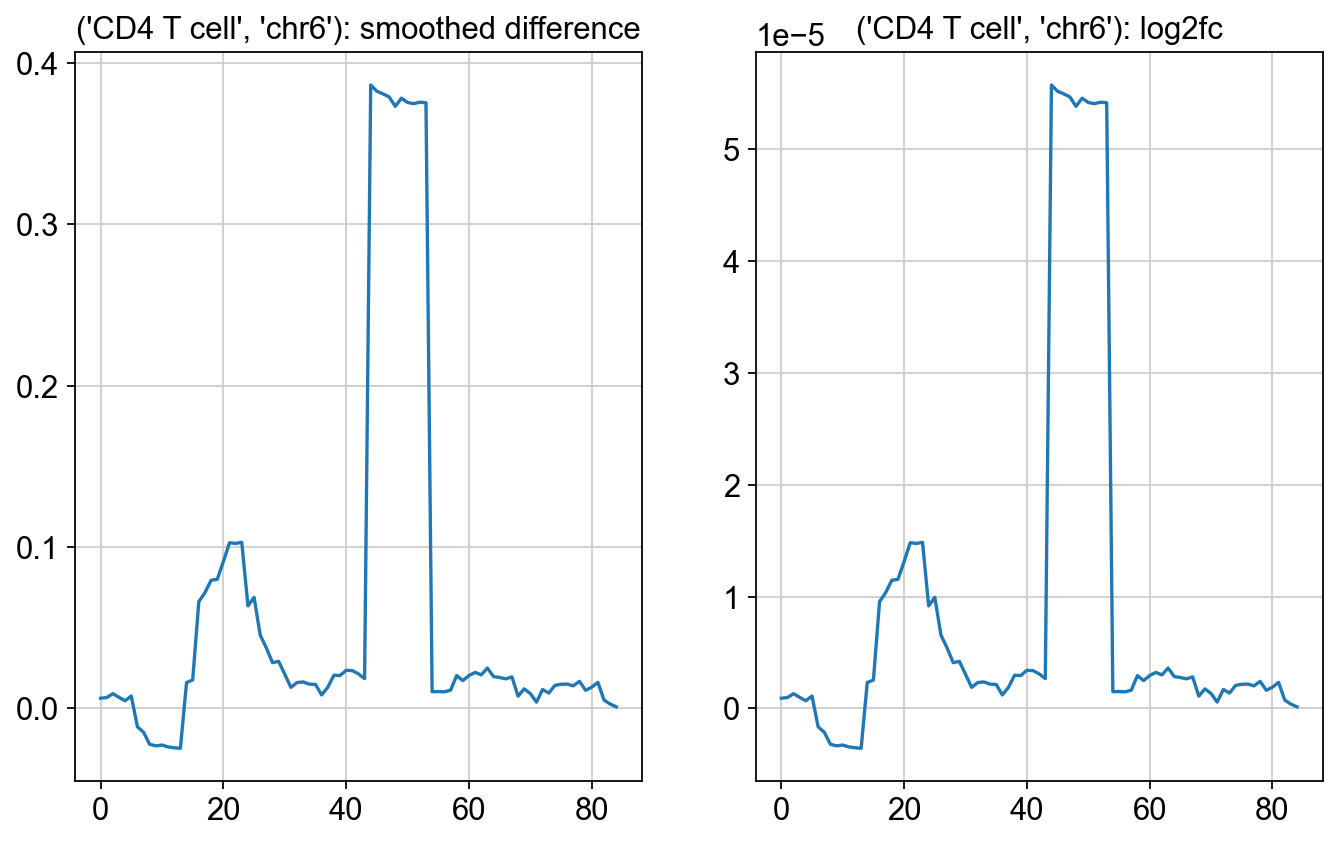

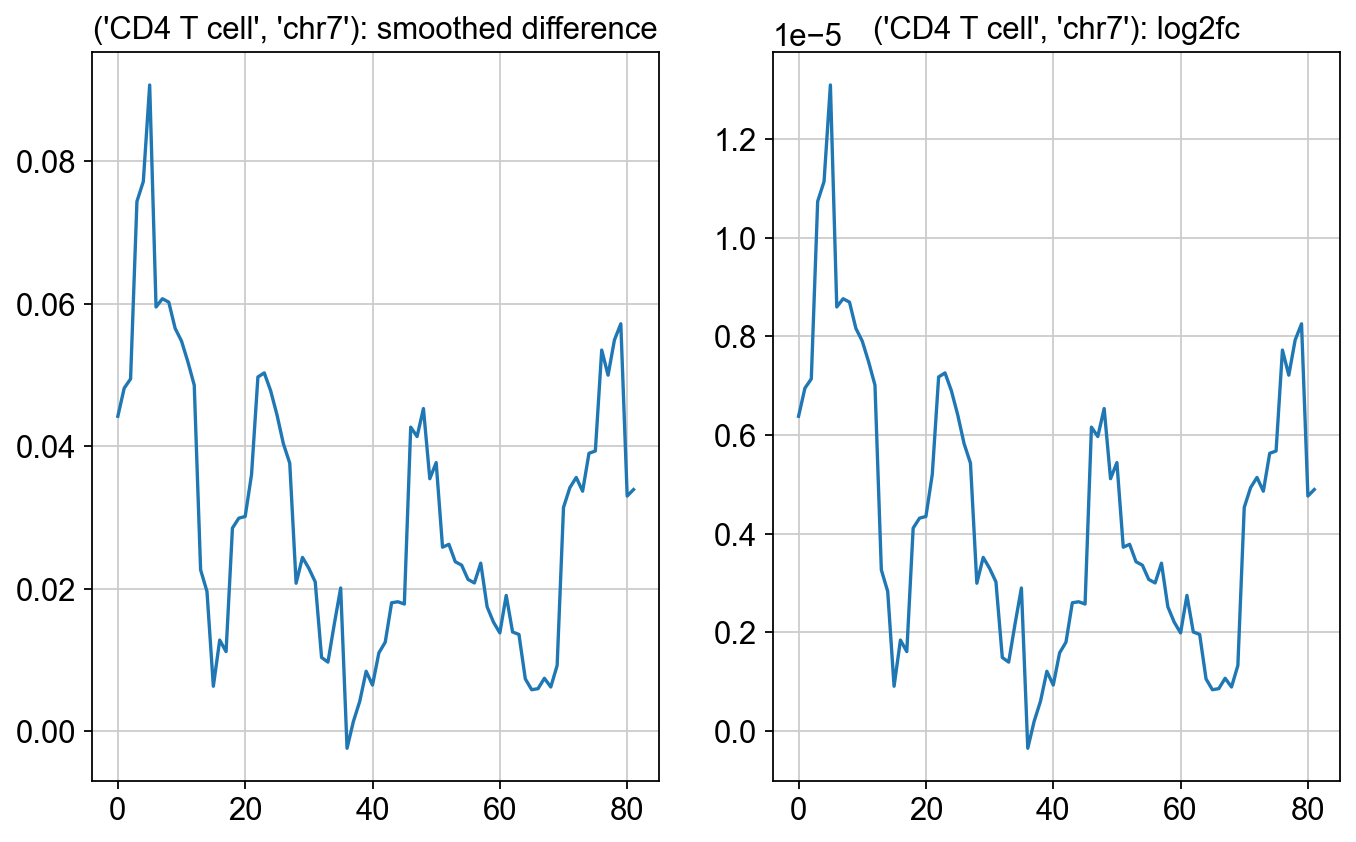

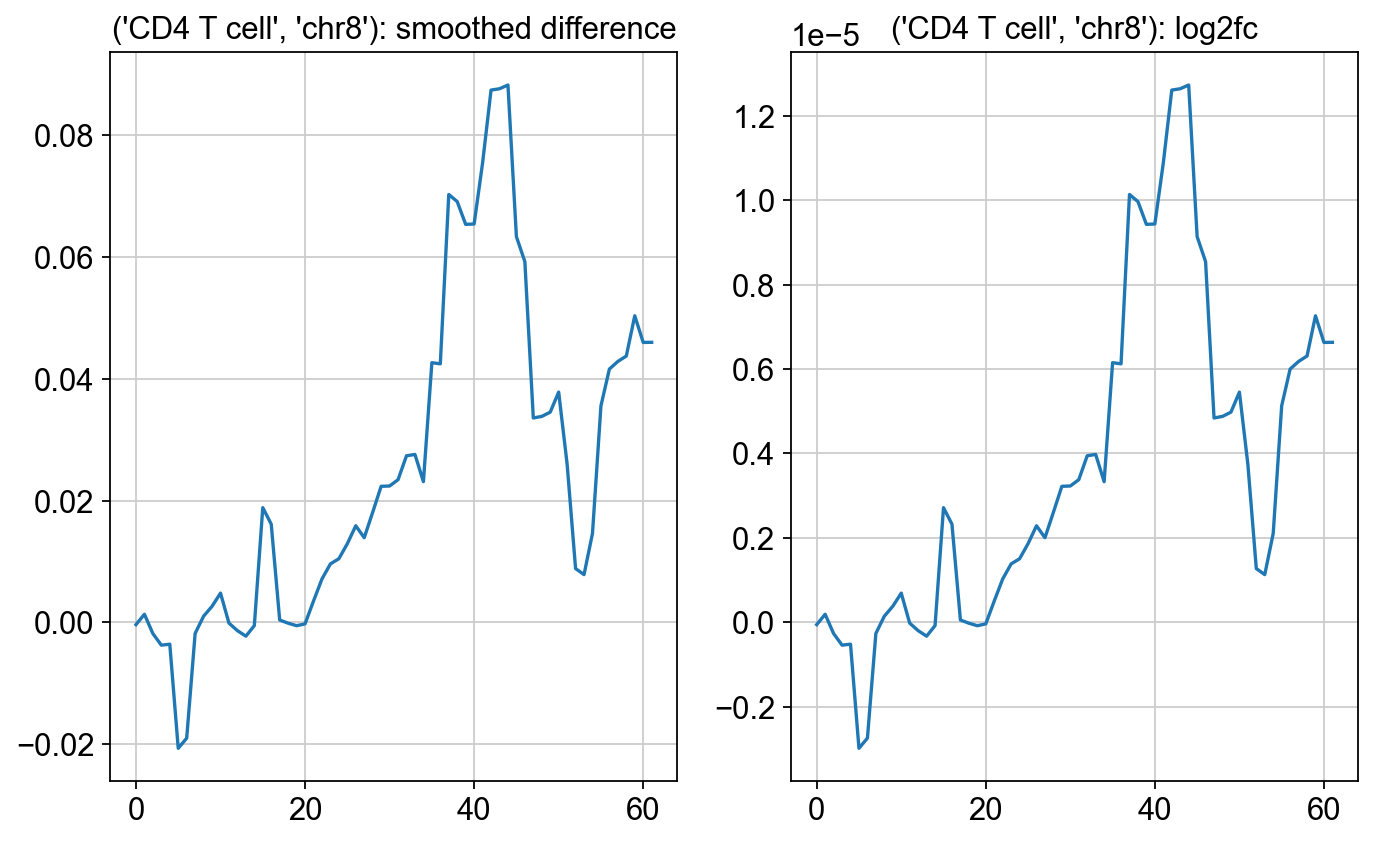

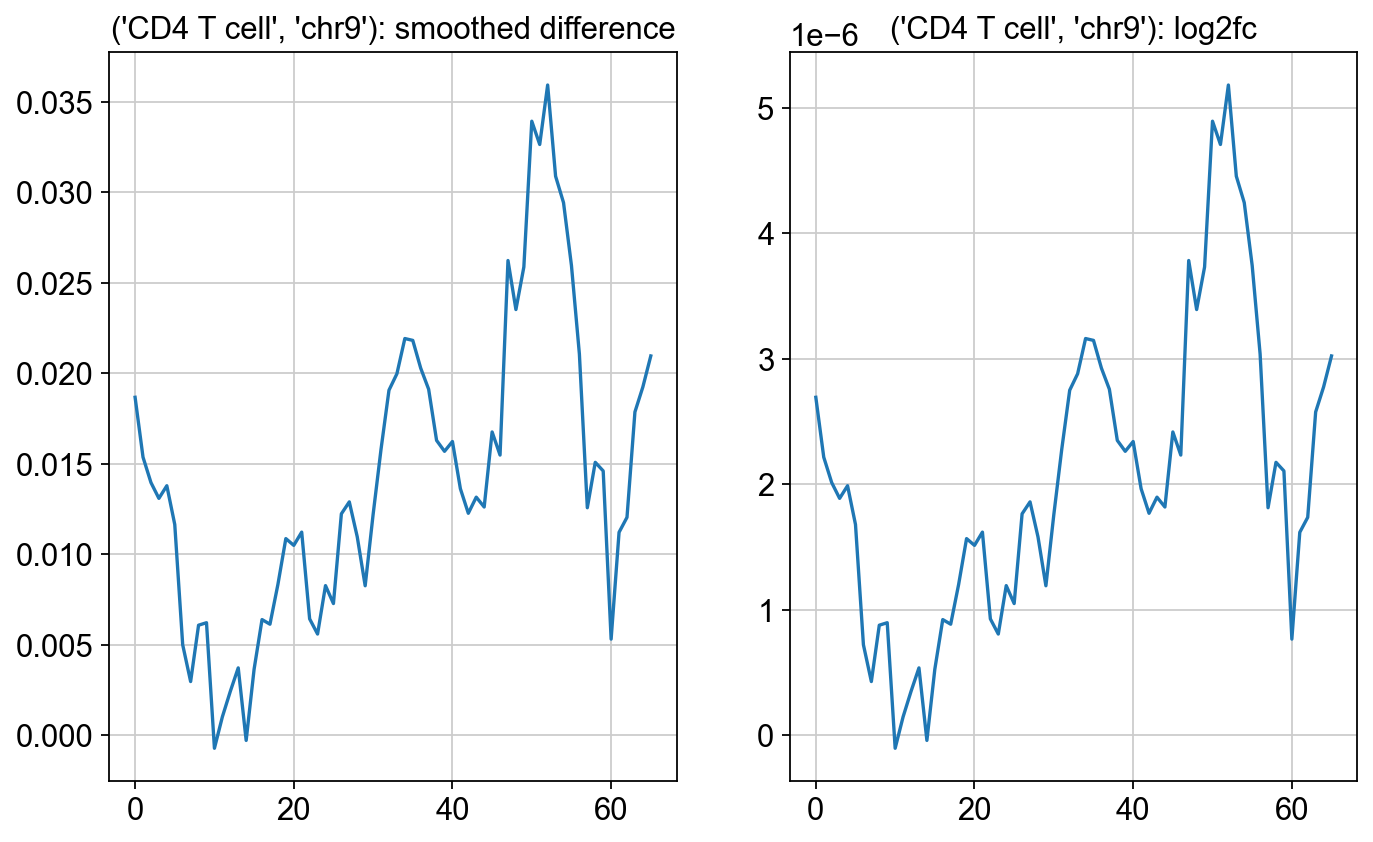

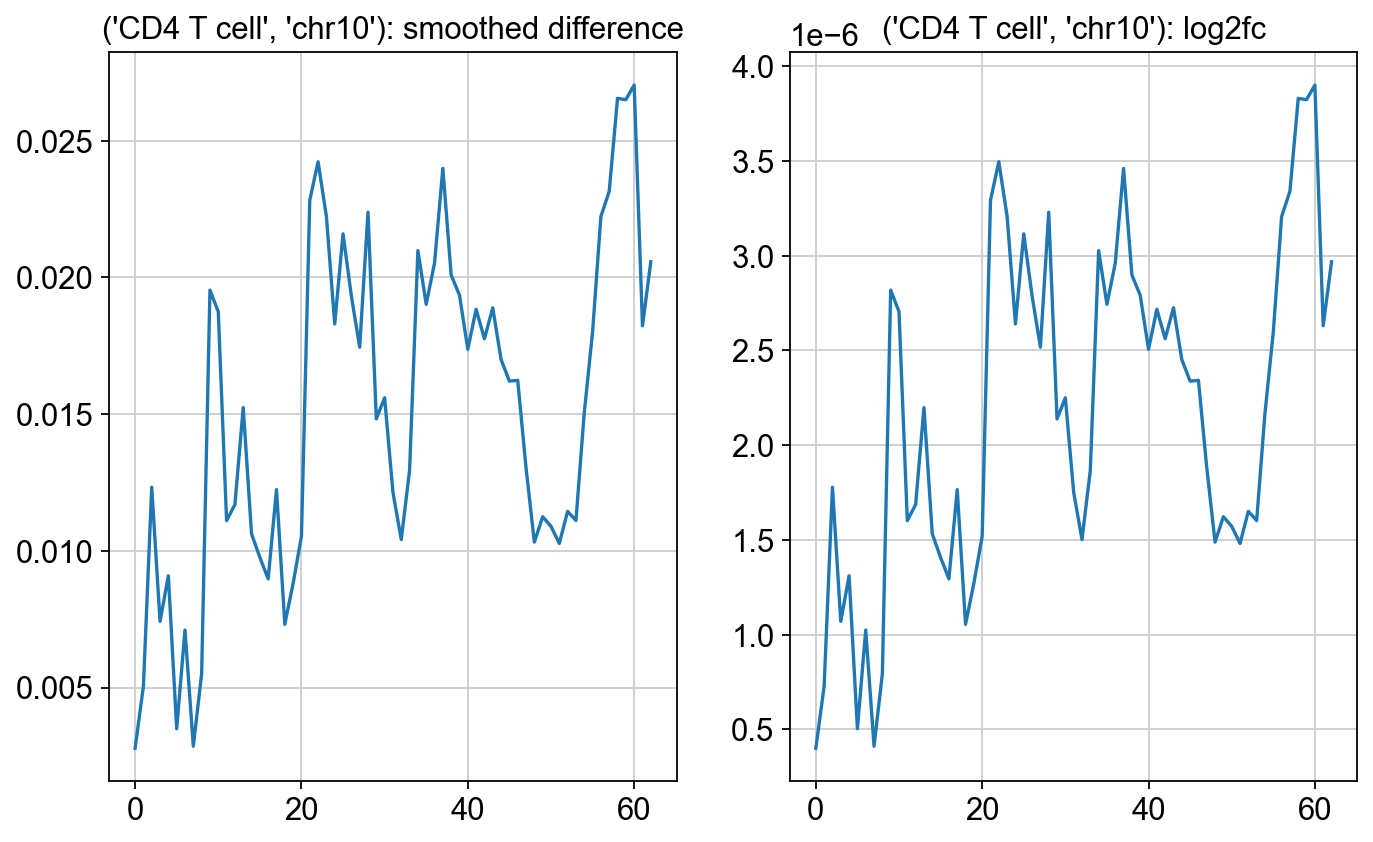

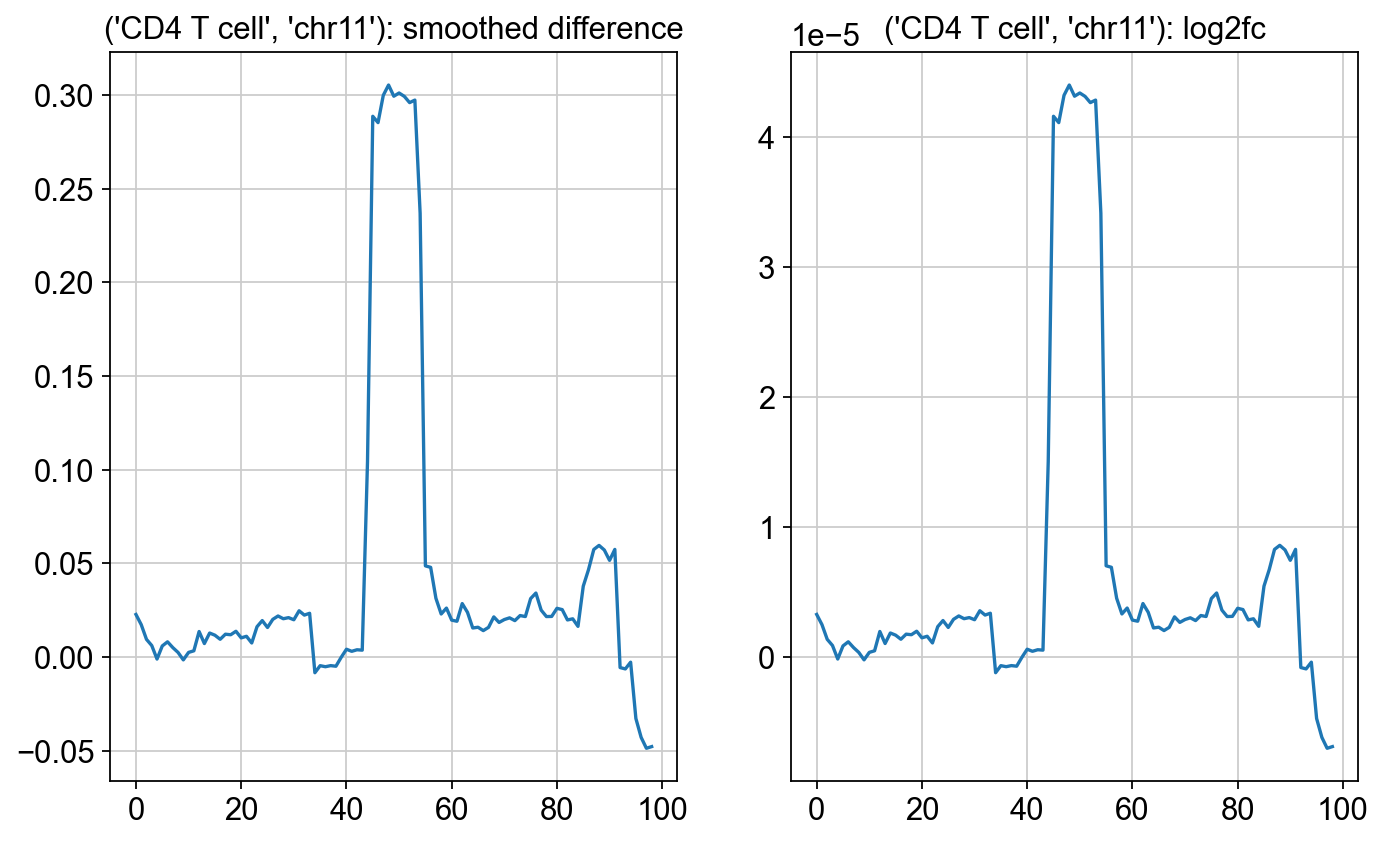

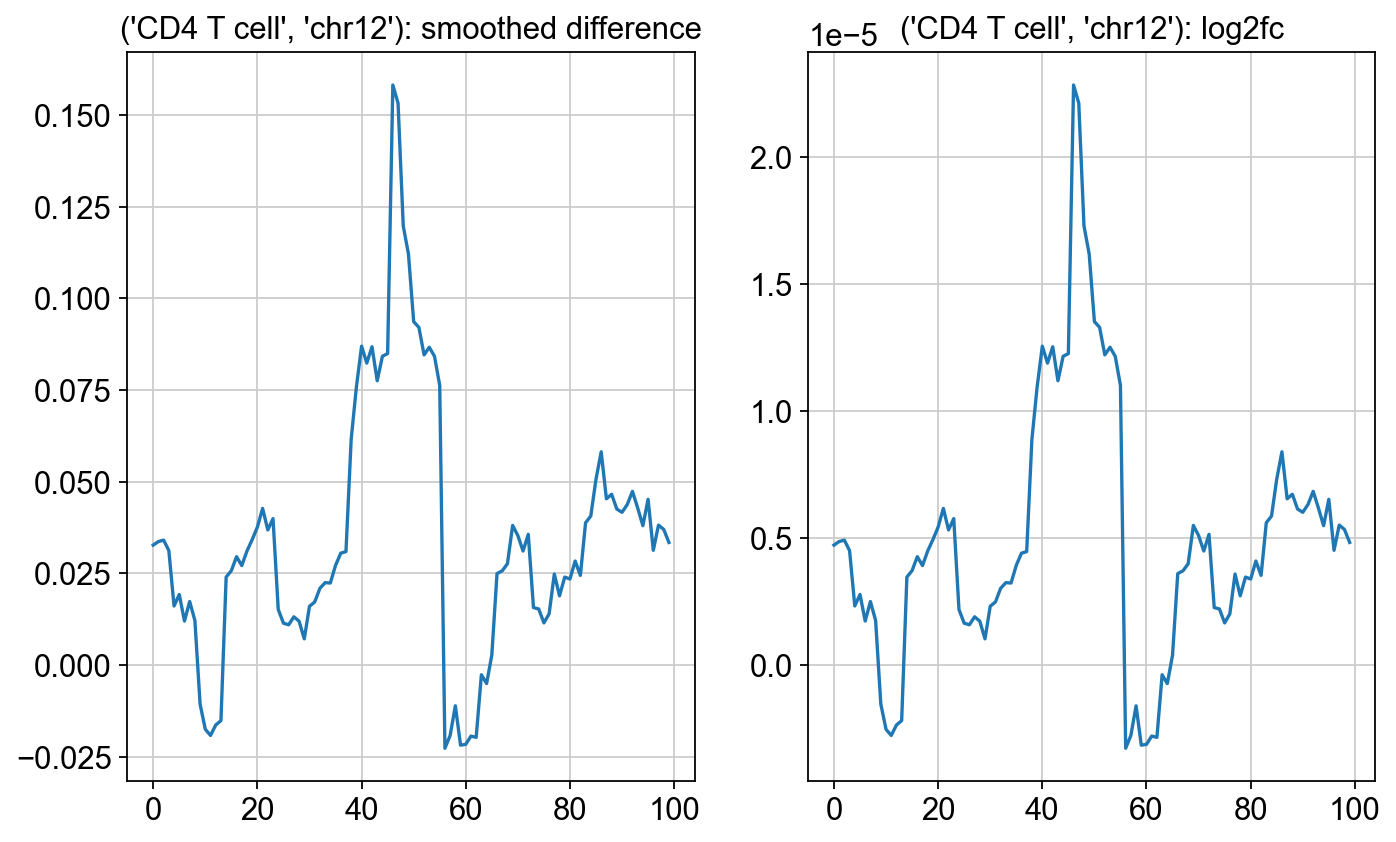

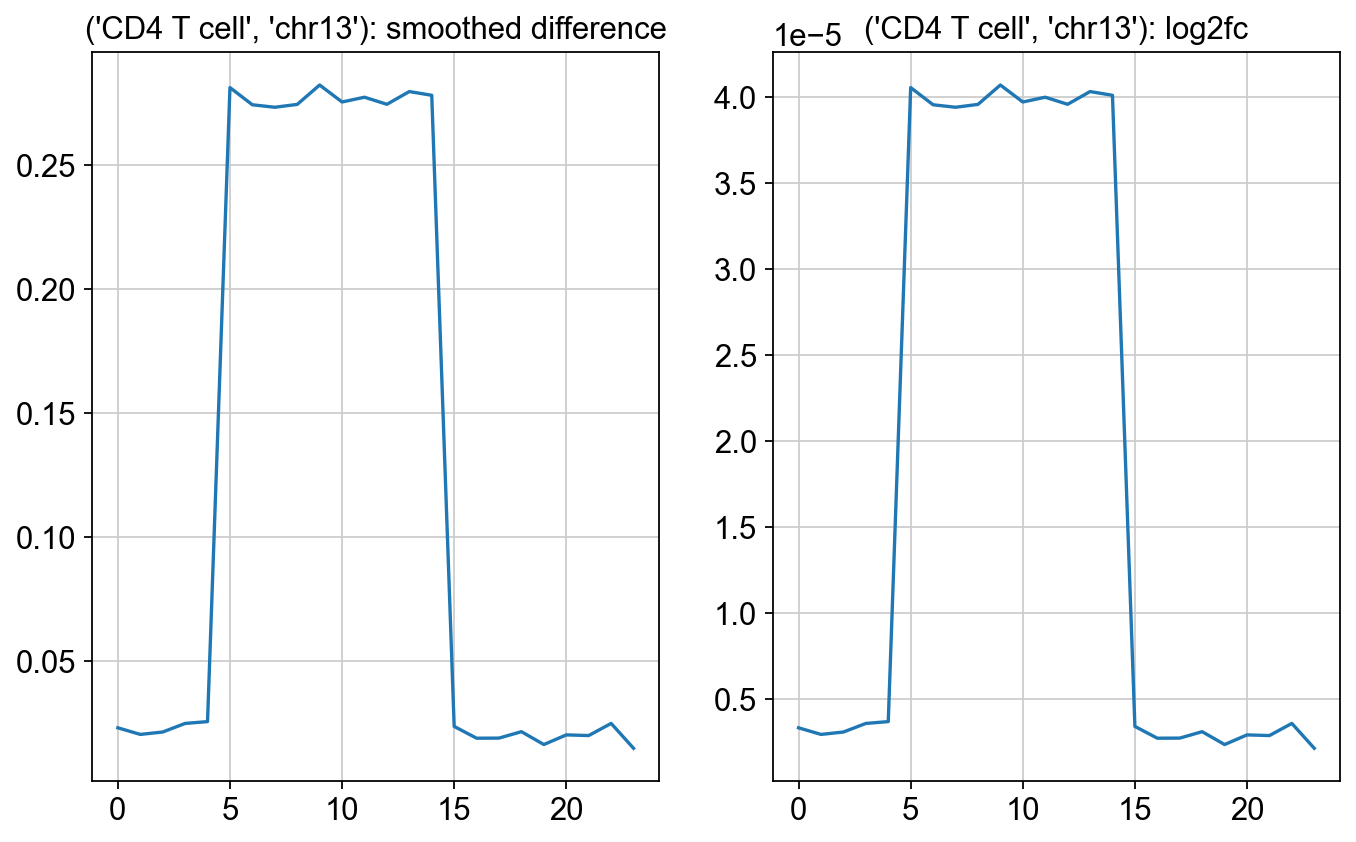

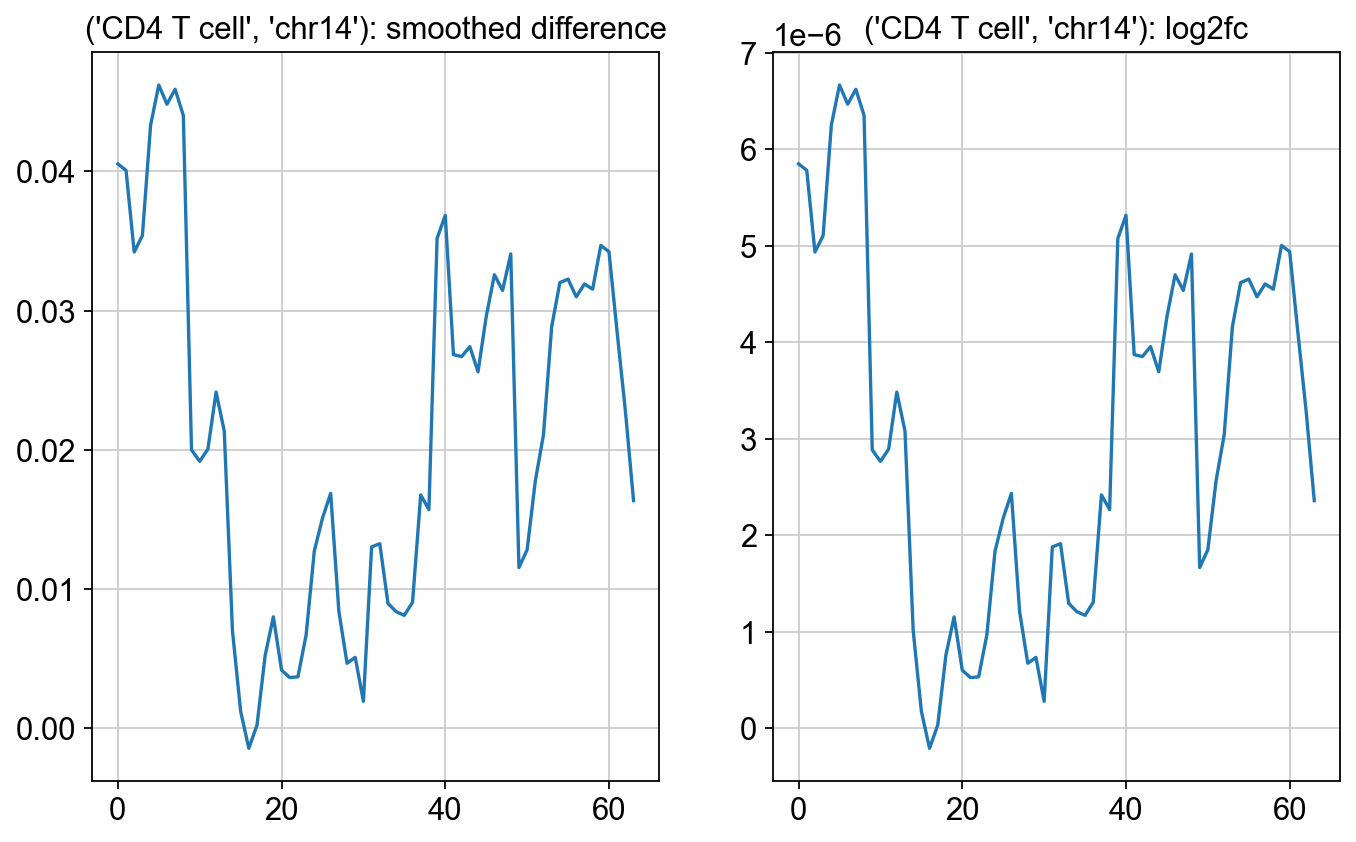

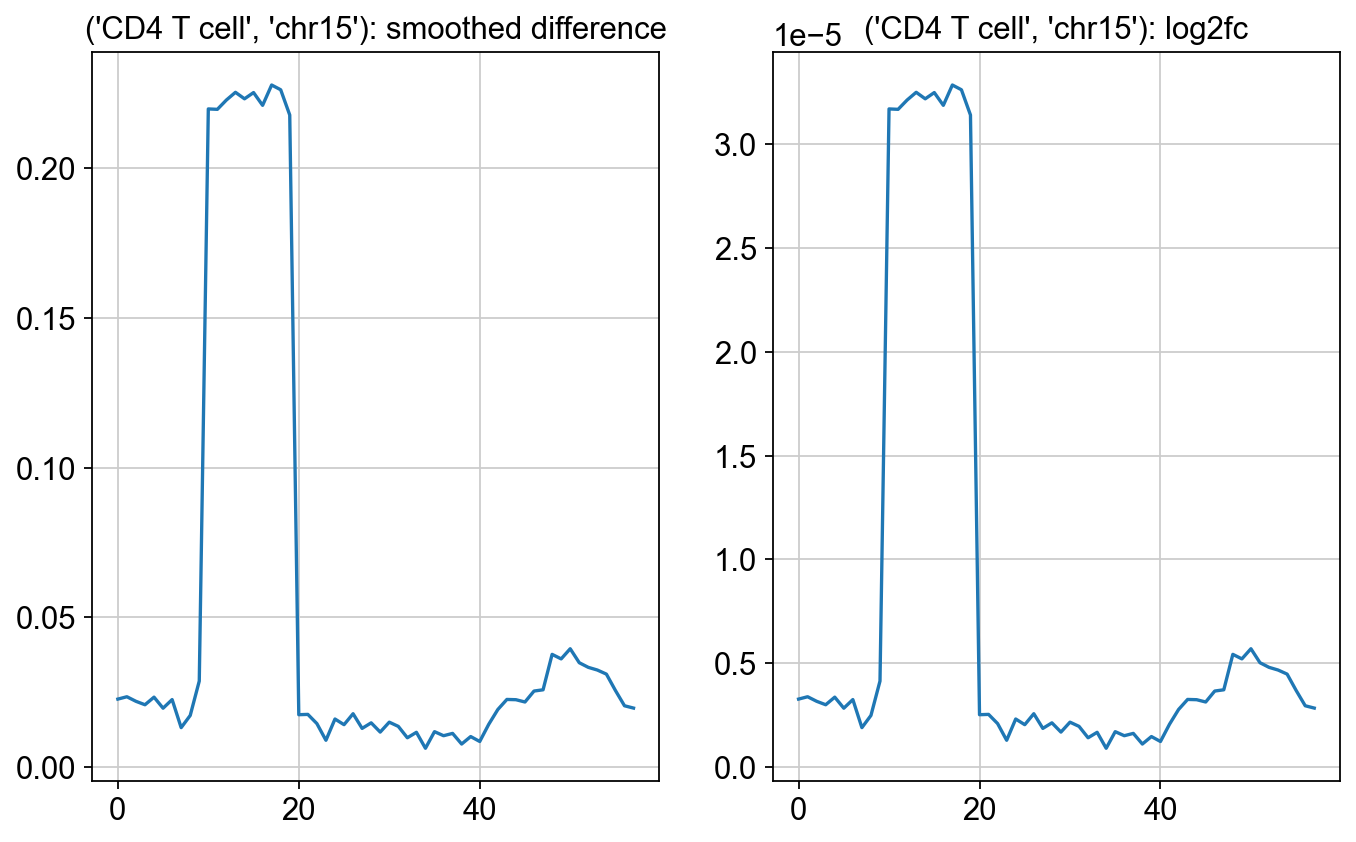

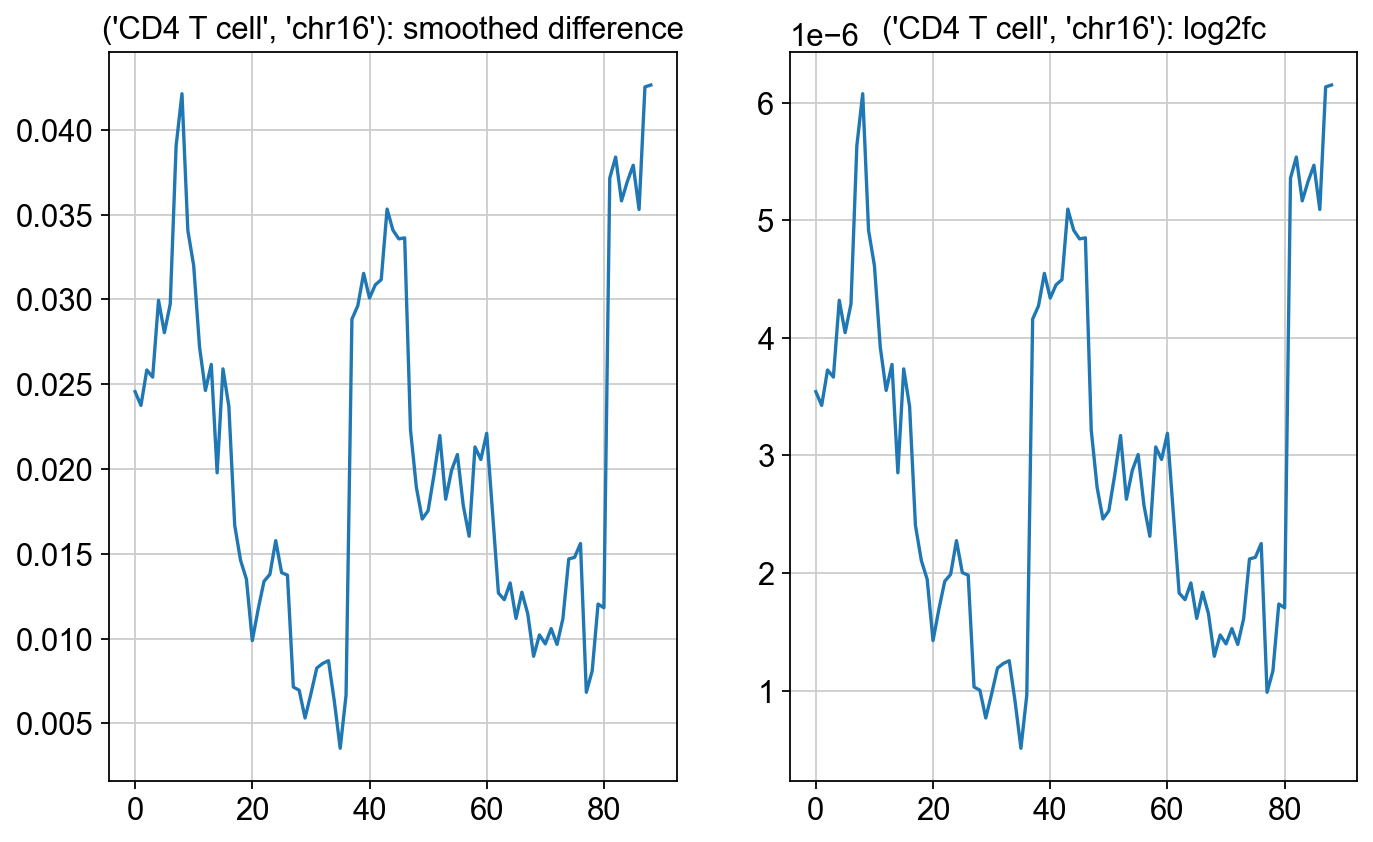

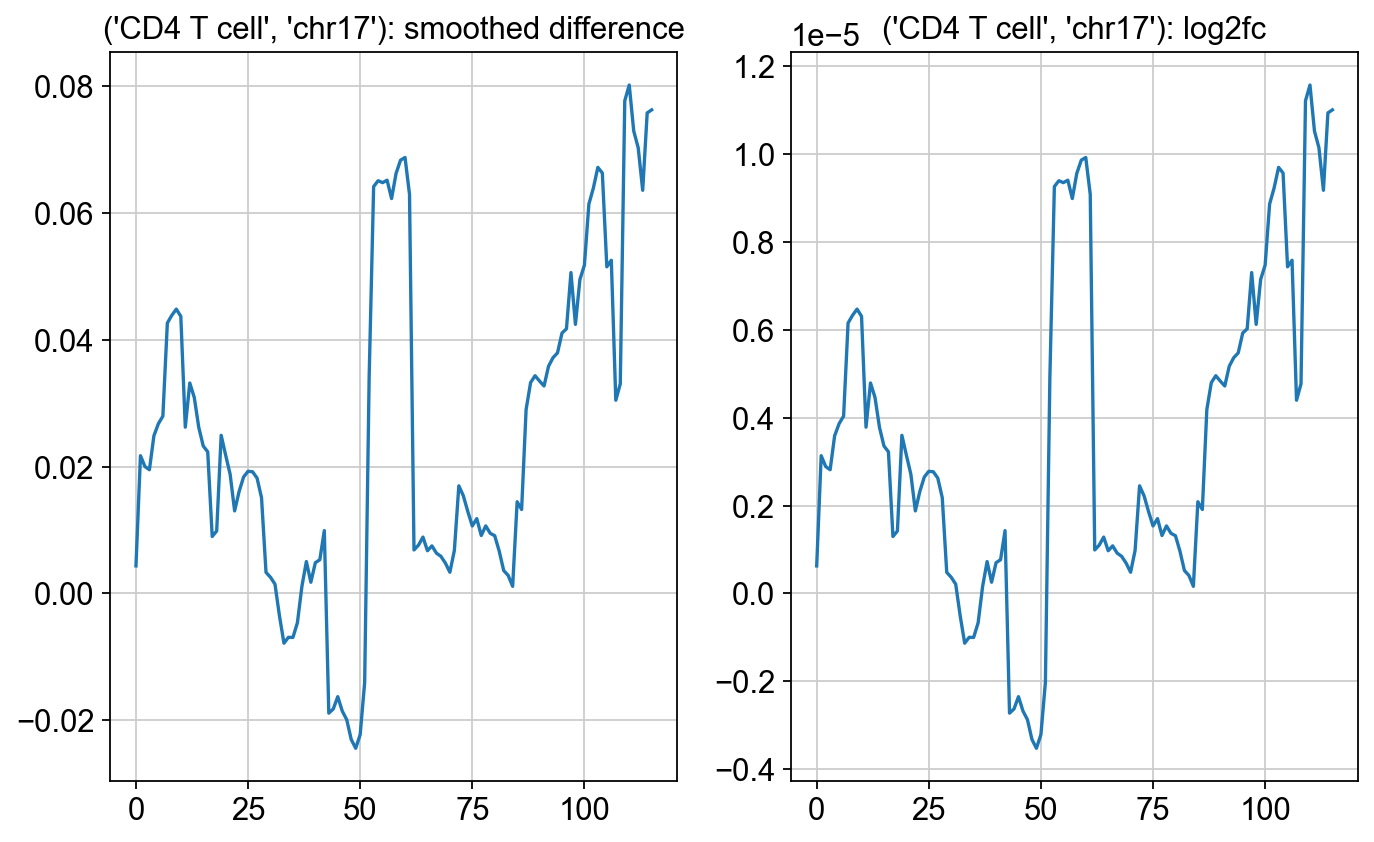

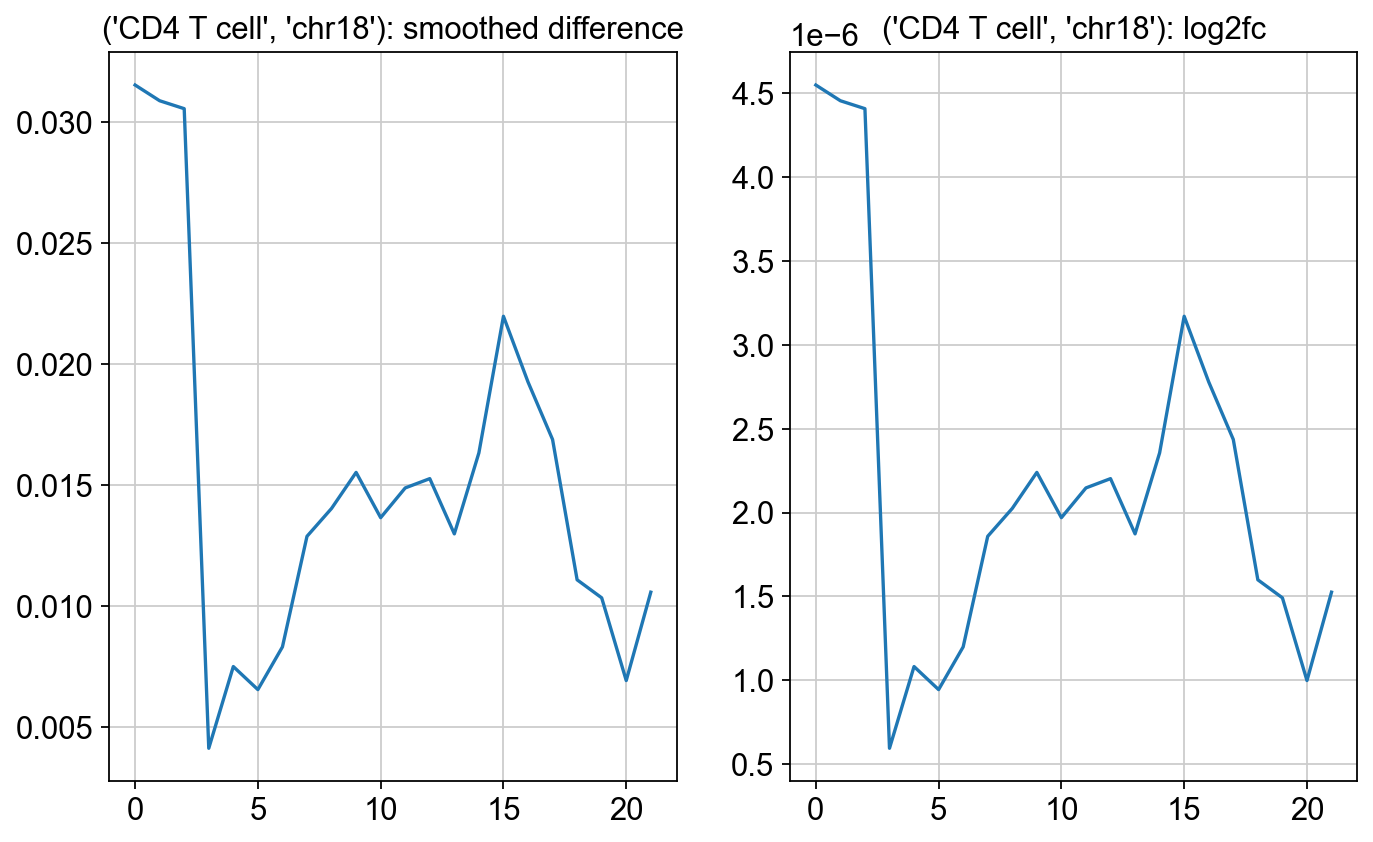

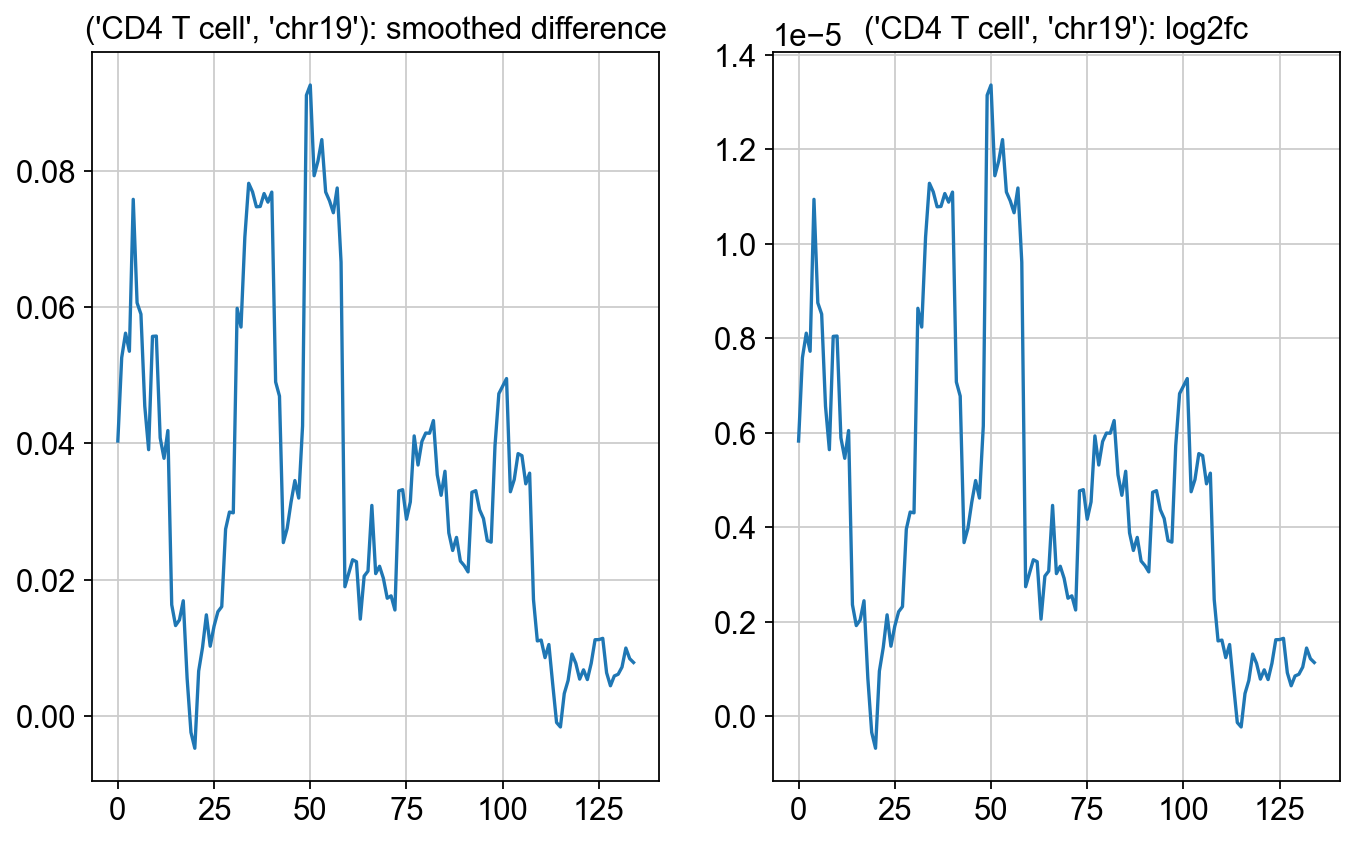

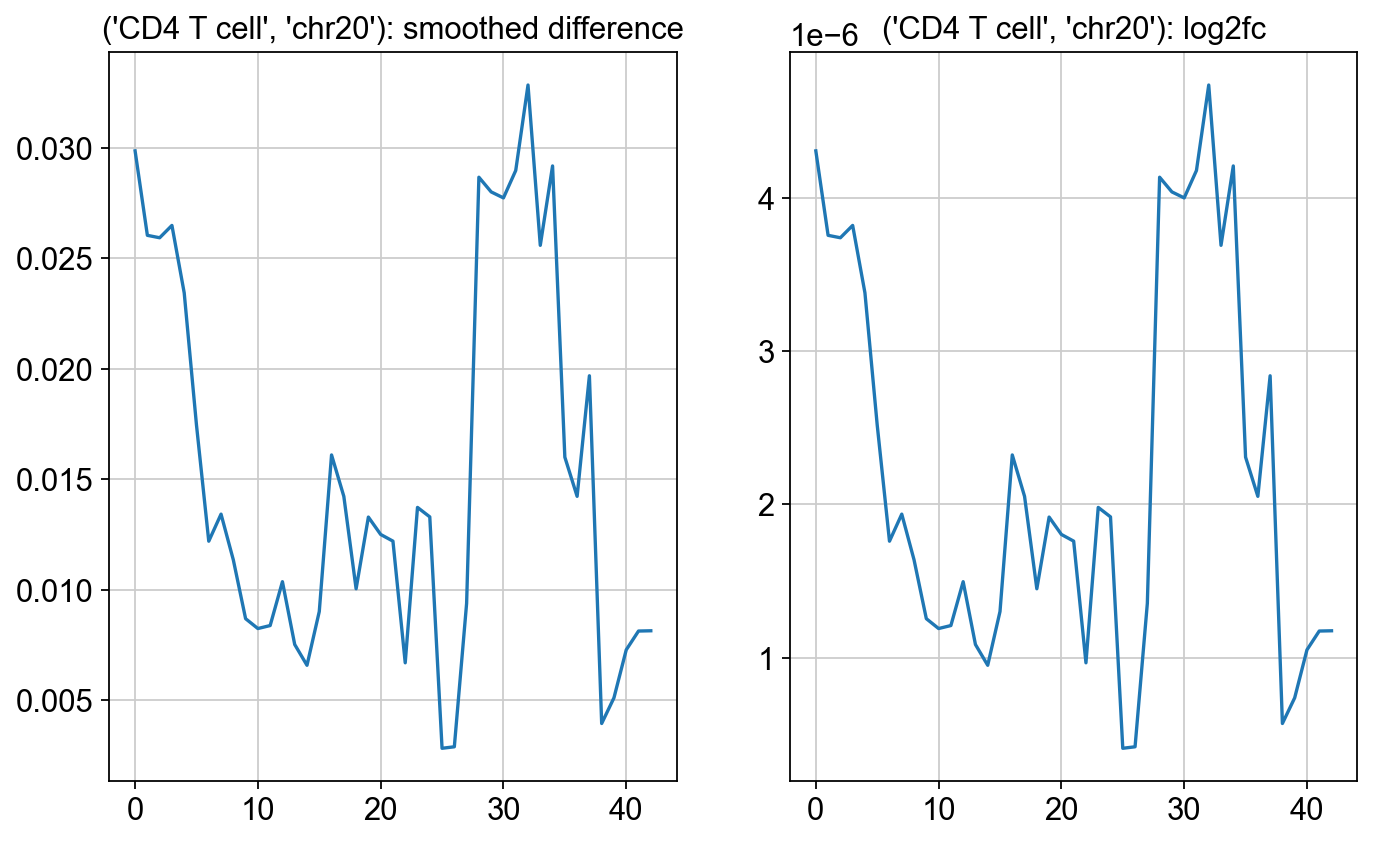

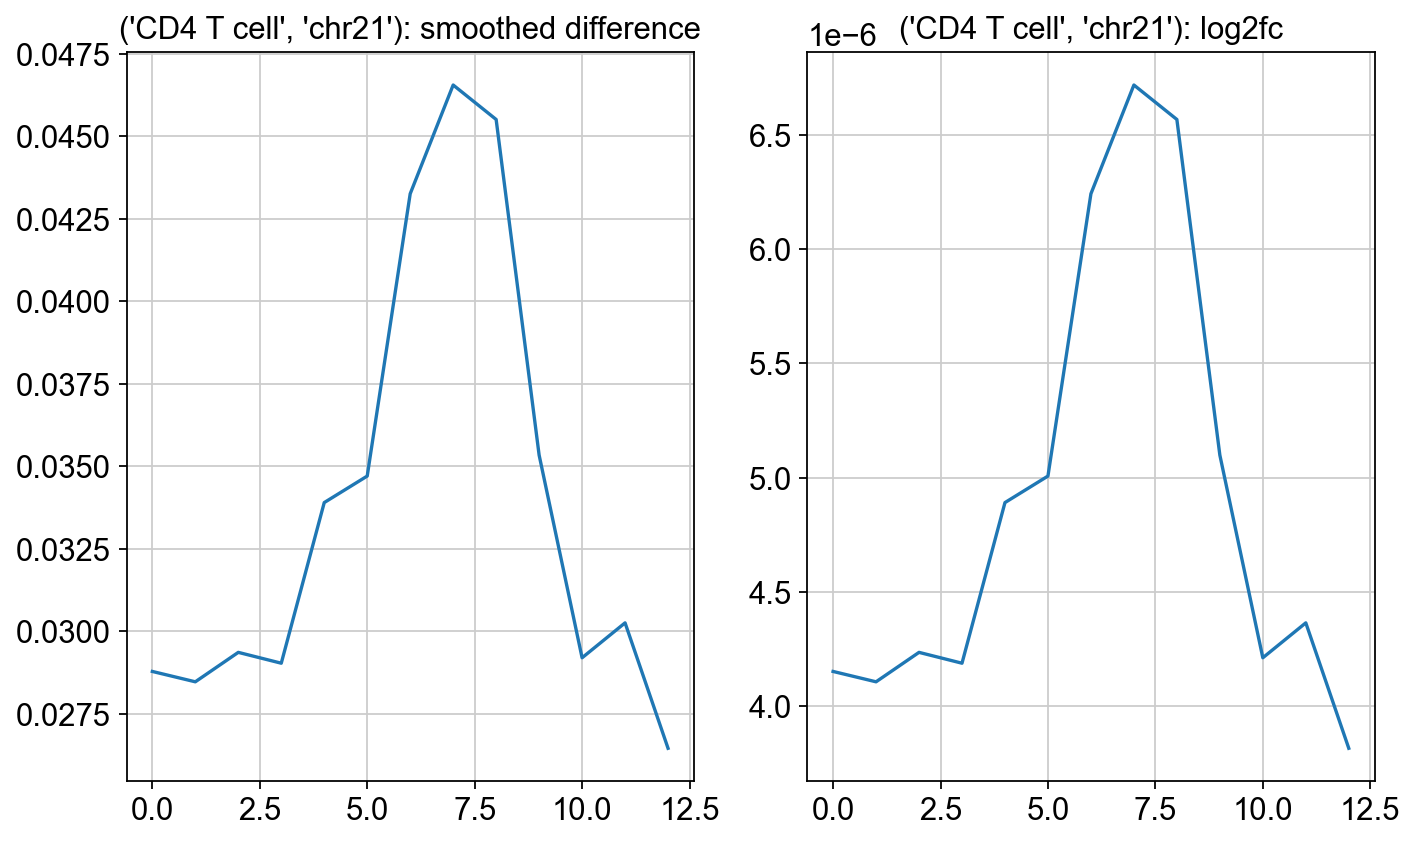

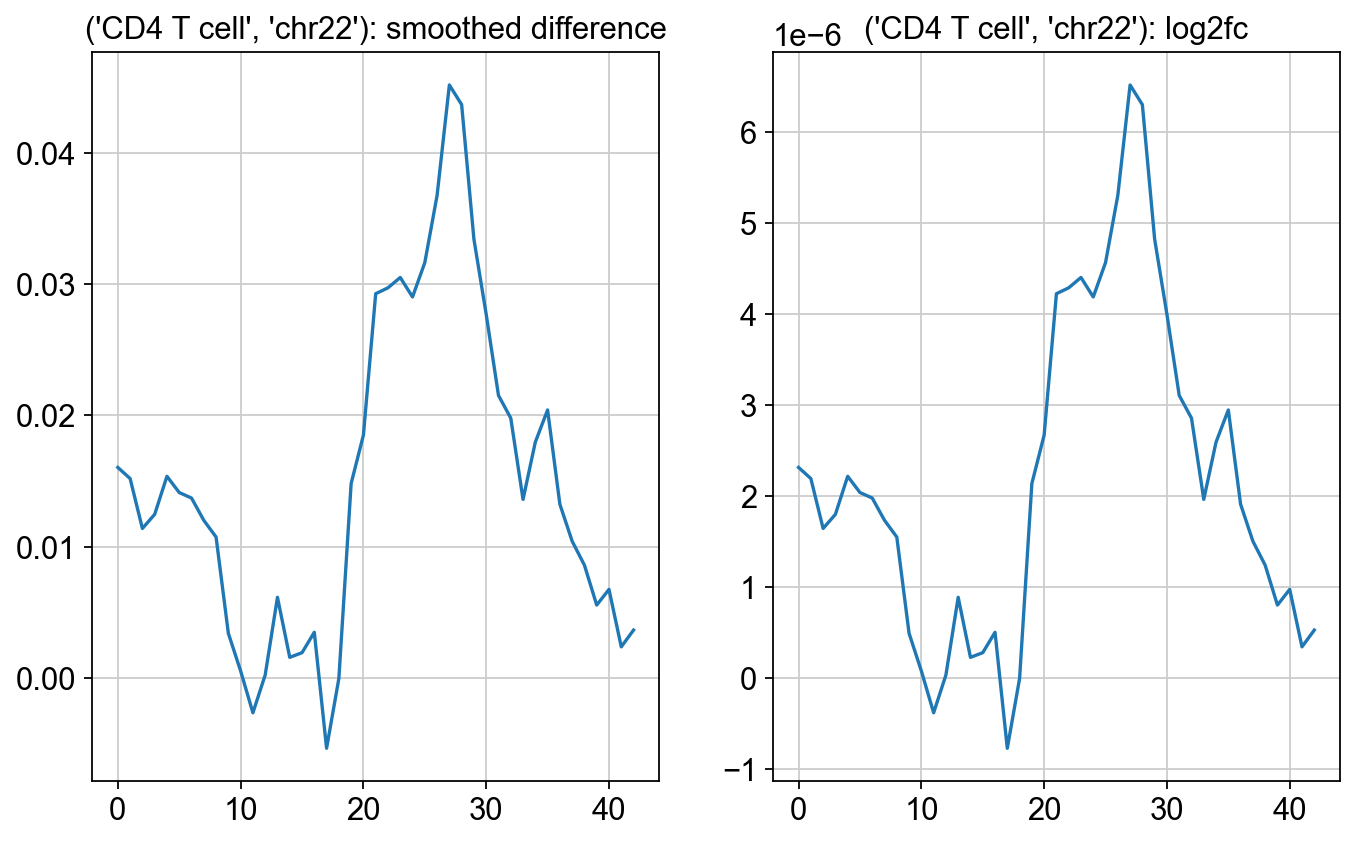

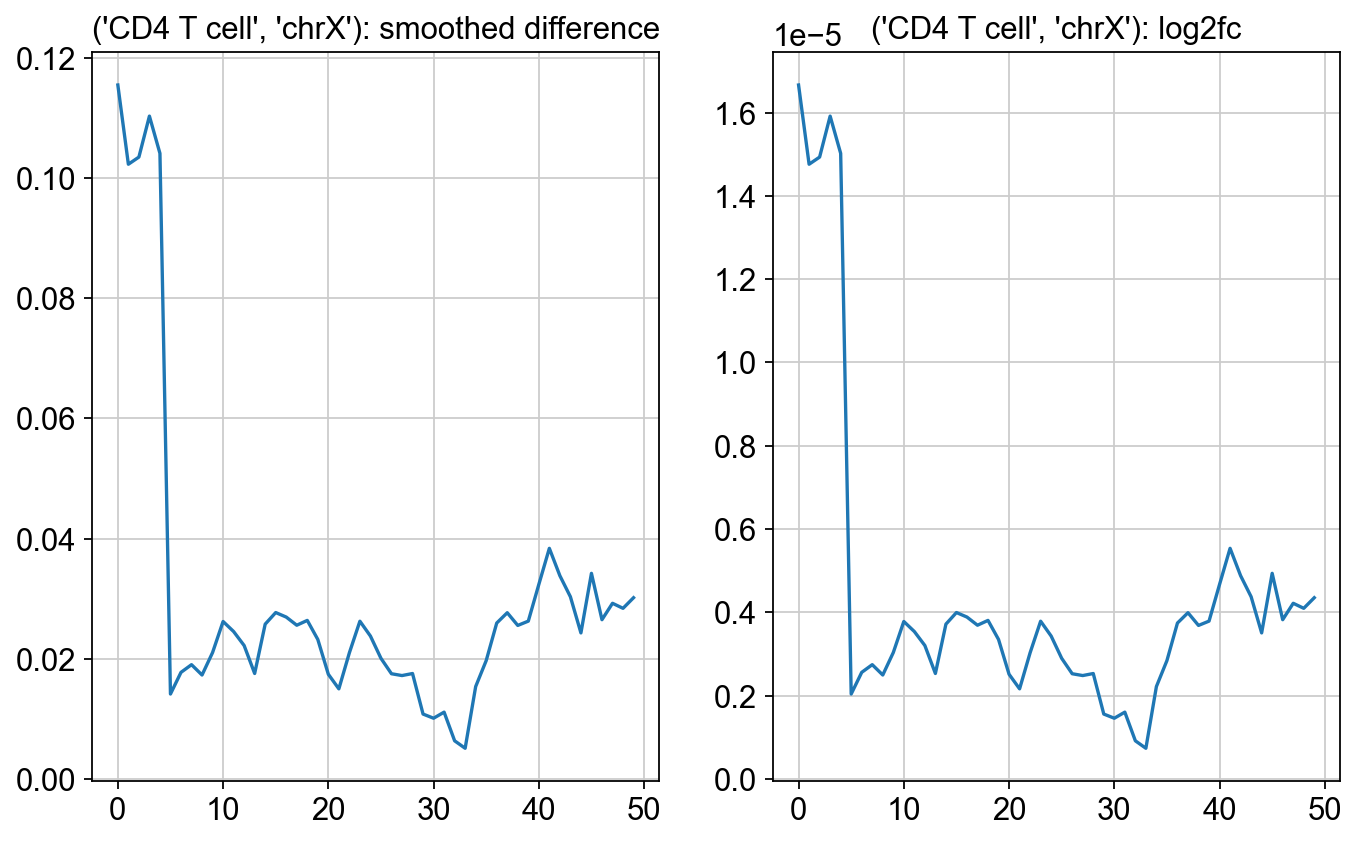

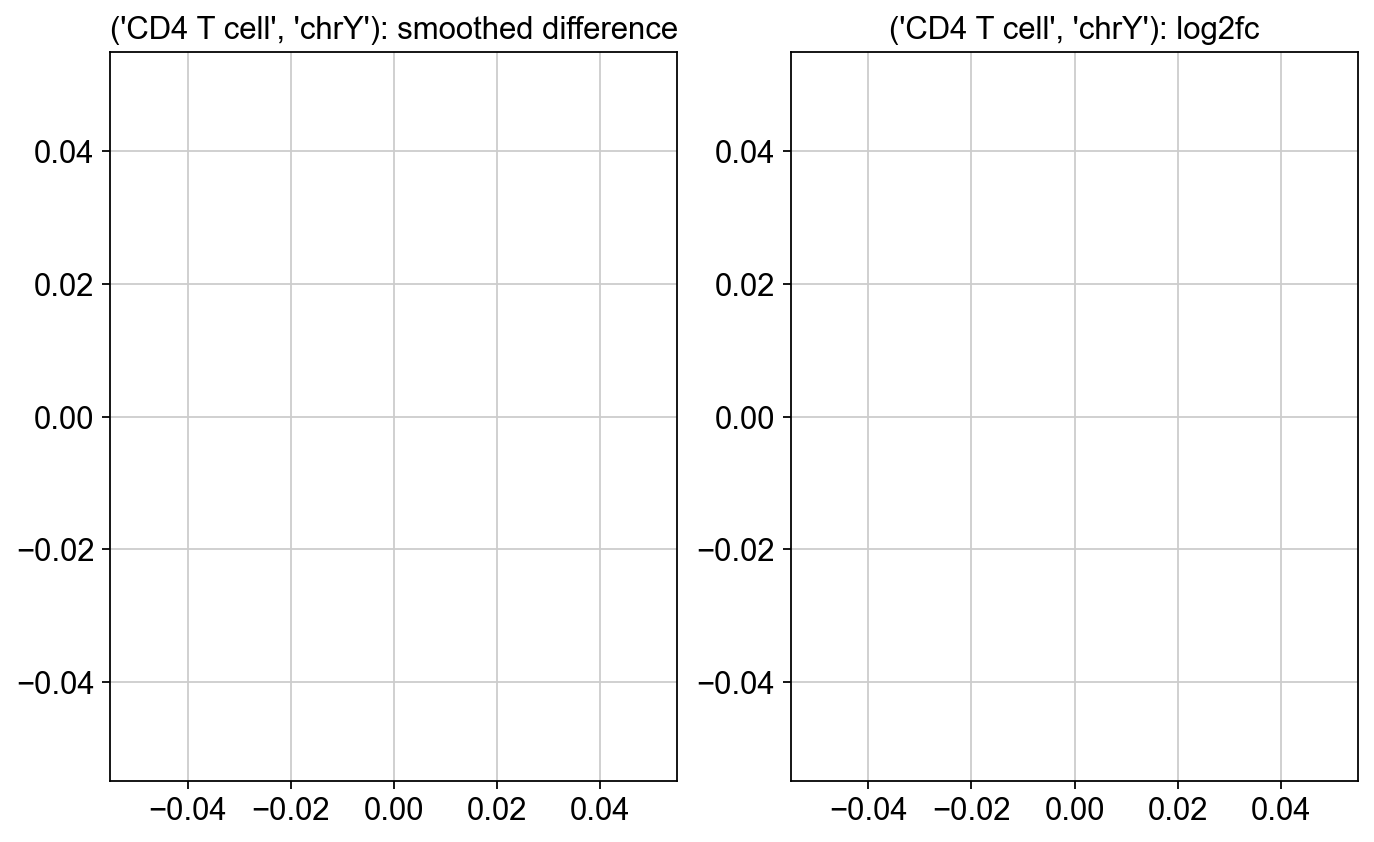

In [14]:
infer_cnvs(adata,
           annotation='cell_type',
           cell_types=['CD14 monocyte','CD4 T cell'],
           window_size=100,
           step=10,
           log2fc_threshold=0.95)